In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

pd.options.display.max_columns = 999

# Precinct Shapefile
---
## VEST's Documentation File


Election Results from South Dakota Secretary of State (https://sdsos.gov/elections-voting/election-resources/election-history/2016_Election_History.aspx)
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release, with the exceptions of Potter County and Yankton County from the 2010 Census VTD release.

Brookings, Brown, Hughes, Hyde, Potter, Sully, and Yankton use countywide vote centers rather than polling locations by precinct. South Dakota counties with vote centers do not record votes by precinct. For these counties, votes were apportioned to precincts based on their share of the countywide number of ballots cast by voters registered with the party of the respective candidates. When this method was tested with counties that report votes by precinct the great majority of precincts were within 4% of the actual candidate vote shares. However, a scattering of precincts deviated by as much as 12% from the actual vote shares. These precincts tend to be in either city centers or outlying areas, which reflects the fact that registered Democrats in rural precincts are more likely to vote for Republican candidates than registered Democrats in urban precincts.

Lawrence County reported absentee votes countywide. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.

The certified precinct report from Minnehaha County adds up to about 18 more votes per office than the countywide totals recorded in the official state canvass. This was evidently an oversight in which the preliminary vote count from Minnehaha County was not updated before the final state canvass.

The following modifications were made in the shapefiles to recreate the 2016 precinct boundaries.

Beadle: Replace 5 commissioner districts with 10 precincts \
Bennett: Merge Martin City wards \
Brown: Adjust 12/16, 21/22; revise Aberdeen city limits to 2016 boundary \
Brule: Merge divisions of 3 \
Butte: Merge 8/13/14 \
Charles Mix: Merge divisions of 3, 6, 11, 12 \
Clark: Replace 5 commissioner districts with 13 precincts \
Codington: 3 county VTDs reorganized into 13 precincts by township list; merge Watertown wards A3/A4, B1/B4/E5, B3/C1, C2/D4, E2/E4; reverse B3 annexation \
Corson: Merge McIntosh/South McIntosh, Lincoln/Oak Creek \
Davison: Merge 4/5, 6/7, 12/13, 17/18 \
Day: Merge divisions of 2, 5, 6; Revise Webster city boundaries \
Dewey: Merge 3/4, 10/11, 12/13 \
Fall River: Merge Edgemont, Oelrichs \
Faulk: Split 6/7 \
Grant: Split 41/45/53, 43/47, 44/49/52/54; Add Milbank wards \
Hand: Merge 1/3, 5/8, 9/10, divisions of 11, 12 \
Hyde: Replace 5 commissioner districts with 3 precincts \
Jackson: Merge divisions of 3, 4 \
Jones: Merge divisions of 1, 3 \
Kingsbury: Replace 5 commissioner districts with 6 precincts \
Lawrence: Merge Whitewood, Rural #1 \
Lincoln: Merge Beresford, Canton 1-3, Canton 4-5, Lennox, Tea \
Mellette: Revise Central/East/West boundaries, White River city limits \
McPherson: Merge Eureka wards with 4/5/6, Leola ward with 1/2 \
Minnehaha: Merge 1-4/1-5, 4-1/5-15, 4-7/4-8, 5-1/5-2; reverse renumbering and changes to corporate boundary since 2016 \
Pennington: Merge CA/SC, HR/LS/RK; Split RH/HC \
Perkins: Merge divisions of 3 \
Potter: Adjust Gettysburg ward boundaries; Merge divisions of 26, 27 \
Roberts: Merge 6/7, 12/14 \
Sully: Revise all precinct boundaries to align with county PDF \
Union: Merge divisions of 2, 6 \
Yankton: Revise Yankton city precincts to align with city limits \
Ziebach: Merge Redelm/N&S Dupree 

* G16PRERTRU - Donald Trump (Republican Party)
* G16PREDCLI - Hillary Clinton (Democratic Party)
* G16PRELJOH - Gary Johnson (Libertarian Party)
* G16PRECCAS - Darrell L. Castle (Constitution Party)


* G16USSRTHU - John R. Thune (Republican Party)
* G16USSDWIL - Jay Williams (Democratic Party)


* G16HALRNOE - Kristi Noem (Republican Party)
* G16HALDHAW - Paula Hawks (Democratic Party)


* G16PUCRNEL - Chris Nelson (Republican Party)
* G16PUCDRED - Henry Red Cloud (Democratic Party)

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/sd_2016/sd_2016.shp")

In [3]:
vest_shp.shape

(747, 15)

In [4]:
vest_shp.head()

STATEFP COUNTYFP   VTDST        NAME  G16PRERTRU  G16PREDCLI  G16PRELJOH  \
0      46      003  0VTD-1  Precinct 1         230          62          11   
1      46      003  0VTD-2  Precinct 2         120          23           7   
2      46      003  0VTD-3  Precinct 3         290         101          19   
3      46      003  0VTD-5  Precinct 5         128          61          11   
4      46      003  0VTD-7  Precinct 7         206          93          26   

   G16PRECCAS  G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  G16PUCRNEL  \
0           4         254          60         229          85         270   
1           3         121          32         107          50         145   
2           6         314         107         262         159         362   
3           1         135          62         128          74         153   
4           5         249          82         203         124         271   

   G16PUCDRED                                           geometry  
0          40  POLYGON Z ((-98.44574 43.75991 0.00000, -98.44...  
1          10  POLYGON Z ((-98.67633 43.49910 0.00000, -98.67...  
2          61  POLYGON Z ((-98.80777 43.93522 0.00000, -98.80...  
3          44  POLYGON Z ((-98.57036 43.93450 0.00000, -98.57...  
4          53  POLYGON Z ((-98.49224 43.72048 0.00000, -98.49...

<AxesSubplot:>

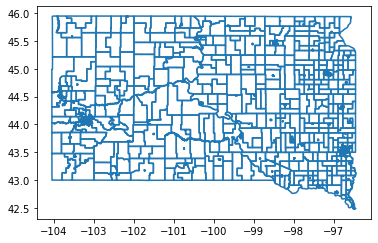

In [5]:
vest_shp.boundary.plot()

## Loading, Combining Election Results
The SOS directed to this link for election results for the 2016 general: https://sdsos.gov/elections-voting/election-resources/election-history/2016_Election_History.aspx

### Presidential Election Results

In [6]:
# Import presidential election results file
pre_16 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - PRE.xlsx")
counties = pre_16.sheet_names

# Create empty list to collect dataframes
df_pre = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(pre_16, sheet_name = county, usecols = [1,2,3,4,5], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_pre.append(df)
# Create the final dataframe    
combined_df_pre = pd.concat(df_pre)
# List county results in alphabetical order for easier merging process later on
combined_df_pre = combined_df_pre.sort_values(by='County')

# Rename the columns to match VEST
combined_df_pre.columns = ['County','Precinct','G16PRERTRU','G16PRELJOH','G16PREDCLI','G16PRECCAS']
# Reorder the columns to match VEST
combined_df_pre = combined_df_pre.reindex(columns=['County','Precinct','G16PRERTRU','G16PREDCLI','G16PRELJOH','G16PRECCAS'])

# Remove the rows with column names and rows with total votes
combined_df_pre = combined_df_pre[combined_df_pre["Precinct"]!="Precinct"]
combined_df_pre = combined_df_pre[combined_df_pre["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_pre = combined_df_pre.fillna(0)

# Deal with the index
combined_df_pre.reset_index(drop=True,inplace=True)

combined_df_pre.head()

County    Precinct  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16PRECCAS
0  Aurora  Precinct-5         128          61          11           1
1  Aurora  Precinct-3         290         101          19           6
2  Aurora  Precinct-2         120          23           7           3
3  Aurora  Precinct-1         230          62          11           4
4  Aurora  Precinct-7         206          93          26           5

### U.S. Senate Election Results

In [7]:
# Import senator election results file
uss_16 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - USS.xlsx")
counties = uss_16.sheet_names

# Create empty list to collect dataframes
df_uss = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(uss_16, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_uss.append(df)
# Create the final dataframe    
combined_df_uss = pd.concat(df_uss)
# List county results in alphabetical order for easier merging process later on
combined_df_uss = combined_df_uss.sort_values(by='County')

# Rename the columns to match VEST
combined_df_uss.columns = ['County','Precinct','G16USSRTHU','G16USSDWIL']

# Remove the rows with column names and rows with total votes
combined_df_uss = combined_df_uss[combined_df_uss["Precinct"]!="Precinct"]
combined_df_uss = combined_df_uss[combined_df_uss["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_uss = combined_df_uss.fillna(0)

# Deal with the index
combined_df_uss.reset_index(drop=True,inplace=True)

combined_df_uss.head()

County    Precinct  G16USSRTHU  G16USSDWIL
0  Aurora  Precinct-5         135          62
1  Aurora  Precinct-3         314         107
2  Aurora  Precinct-2         121          32
3  Aurora  Precinct-1         254          60
4  Aurora  Precinct-7         249          82

### U.S. Representative

In [8]:
# Import representative election results file
hal_16 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - HAL.xlsx")
counties = hal_16.sheet_names

# Create empty list to collect dataframes
df_hal = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(hal_16, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_hal.append(df)
# Create the final dataframe    
combined_df_hal = pd.concat(df_hal)
# List county results in alphabetical order for easier merging process later on
combined_df_hal = combined_df_hal.sort_values(by='County')

# Rename the columns to match VEST
combined_df_hal.columns = ['County','Precinct','G16HALRNOE','G16HALDHAW']

# Remove the rows with column names and rows with total votes
combined_df_hal = combined_df_hal[combined_df_hal["Precinct"]!="Precinct"]
combined_df_hal = combined_df_hal[combined_df_hal["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_hal = combined_df_hal.fillna(0)

# Deal with the index
combined_df_hal.reset_index(drop=True,inplace=True)

combined_df_hal.head()

County    Precinct  G16HALRNOE  G16HALDHAW
0  Aurora  Precinct-5         128          74
1  Aurora  Precinct-3         262         159
2  Aurora  Precinct-2         107          50
3  Aurora  Precinct-1         229          85
4  Aurora  Precinct-7         203         124

### Public Utilities Commissioner Election Results

In [9]:
# Import PUC election results file
puc_16 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - PUC.xlsx")
counties = puc_16.sheet_names

# Create empty list to collect dataframes
df_puc = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(puc_16, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_puc.append(df)
# Create the final dataframe    
combined_df_puc = pd.concat(df_puc)
# List county results in alphabetical order for easier merging process later on
combined_df_puc = combined_df_puc.sort_values(by='County')

# Rename the columns to match VEST
combined_df_puc.columns = ['County','Precinct','G16PUCRNEL','G16PUCDRED']

# Remove the rows with column names and rows with total votes
combined_df_puc = combined_df_puc[combined_df_puc["Precinct"]!="Precinct"]
combined_df_puc = combined_df_puc[combined_df_puc["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_puc = combined_df_puc.fillna(0)

# Deal with the index
combined_df_puc.reset_index(drop=True,inplace=True)

combined_df_puc.head()

County    Precinct  G16PUCRNEL  G16PUCDRED
0  Aurora  Precinct-5         153          44
1  Aurora  Precinct-3         362          61
2  Aurora  Precinct-2         145          10
3  Aurora  Precinct-1         270          40
4  Aurora  Precinct-7         271          53

### Combine Results

In [10]:
# Concatenate all dataframes
sd_16 = pd.concat([combined_df_pre,combined_df_uss,combined_df_hal,combined_df_puc],axis=1)

# Drop repeated column (County)
sd_16 = sd_16.loc[:,~sd_16.columns.duplicated()]


# Display results in alphabetical order of the counties and precincts
sd_16 = sd_16.sort_values(by =['County','Precinct'], ascending = True)

# Make sure the number of votes are recorded in the form of integers (Change if not - County and Precinct columns remain unchanged)
sd_16 = sd_16.apply(pd.to_numeric, errors='ignore')

# Make sure the county names and precinct names are in string form
sd_16['County'] = sd_16['County'].astype(str)
sd_16['Precinct'] = sd_16['Precinct'].astype(str)

sd_16.head()

County    Precinct  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16PRECCAS  \
3  Aurora  Precinct-1         230          62          11           4   
2  Aurora  Precinct-2         120          23           7           3   
1  Aurora  Precinct-3         290         101          19           6   
0  Aurora  Precinct-5         128          61          11           1   
4  Aurora  Precinct-7         206          93          26           5   

   G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  G16PUCRNEL  G16PUCDRED  
3         254          60         229          85         270          40  
2         121          32         107          50         145          10  
1         314         107         262         159         362          61  
0         135          62         128          74         153          44  
4         249          82         203         124         271          53

### Add in FIPS File

In [11]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="South Dakota"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Make FIPS County Name uppercase
fips_file['County Name']=fips_file['County Name'].str.upper()

#Create the dictionary
sd_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# Modify county names in dataframe to match the FIPs file
# Oglala Lakota county was originally named Shannon county - the county was renamed in 2015
county_name_changes_dict = {"Oglala Lakota":"Shannon"}
sd_16["County"] = sd_16["County"].map(county_name_changes_dict).fillna(sd_16["County"])

In [12]:
sd_fips_dict

{'AURORA': '003',
 'BEADLE': '005',
 'BENNETT': '007',
 'BON HOMME': '009',
 'BROOKINGS': '011',
 'BROWN': '013',
 'BRULE': '015',
 'BUFFALO': '017',
 'BUTTE': '019',
 'CAMPBELL': '021',
 'CHARLES MIX': '023',
 'CLARK': '025',
 'CLAY': '027',
 'CODINGTON': '029',
 'CORSON': '031',
 'CUSTER': '033',
 'DAVISON': '035',
 'DAY': '037',
 'DEUEL': '039',
 'DEWEY': '041',
 'DOUGLAS': '043',
 'EDMUNDS': '045',
 'FALL RIVER': '047',
 'FAULK': '049',
 'GRANT': '051',
 'GREGORY': '053',
 'HAAKON': '055',
 'HAMLIN': '057',
 'HAND': '059',
 'HANSON': '061',
 'HARDING': '063',
 'HUGHES': '065',
 'HUTCHINSON': '067',
 'HYDE': '069',
 'JACKSON': '071',
 'JERAULD': '073',
 'JONES': '075',
 'KINGSBURY': '077',
 'LAKE': '079',
 'LAWRENCE': '081',
 'LINCOLN': '083',
 'LYMAN': '085',
 'MCCOOK': '087',
 'MCPHERSON': '089',
 'MARSHALL': '091',
 'MEADE': '093',
 'MELLETTE': '095',
 'MINER': '097',
 'MINNEHAHA': '099',
 'MOODY': '101',
 'PENNINGTON': '103',
 'PERKINS': '105',
 'POTTER': '107',
 'ROBERTS': '109

In [13]:
sd_16["County"].unique()

array(['Aurora', 'Beadle', 'Bennett', 'Bon Homme', 'Brookings', 'Brown',
       'Brule', 'Buffalo', 'Butte', 'Campbell', 'Charles Mix', 'Clark',
       'Clay', 'Codington', 'Corson', 'Custer', 'Davison', 'Day', 'Deuel',
       'Dewey', 'Douglas', 'Edmunds', 'Fall River', 'Faulk', 'Grant',
       'Gregory', 'Haakon', 'Hamlin', 'Hand', 'Hanson', 'Harding',
       'Hughes', 'Hutchinson', 'Hyde', 'Jackson', 'Jerauld', 'Jones',
       'Kingsbury', 'Lake', 'Lawrence', 'Lincoln', 'Lyman', 'Marshall',
       'McCook', 'McPherson', 'Meade', 'Mellette', 'Miner', 'Minnehaha',
       'Moody', 'Shannon', 'Pennington', 'Perkins', 'Potter', 'Roberts',
       'Sanborn', 'Spink', 'Stanley', 'Sully', 'Todd', 'Tripp', 'Turner',
       'Union', 'Walworth', 'Yankton', 'Ziebach'], dtype=object)

In [14]:
county_dict = {'Aurora':'AURORA', 'Beadle':'BEADLE', 'Bennett':'BENNETT', 'Bon Homme':'BON HOMME', 'Brookings':'BROOKINGS', 'Brown':'BROWN',
       'Brule':'BRULE', 'Buffalo':'BUFFALO', 'Butte':'BUTTE', 'Campbell':'CAMPBELL', 'Charles Mix':'CHARLES MIX', 'Clark':'CLARK',
       'Clay':'CLAY', 'Codington':'CODINGTON', 'Corson':'CORSON', 'Custer':'CUSTER', 'Davison':'DAVISON', 'Day':'DAY', 'Deuel':'DEUEL',
       'Dewey':'DEWEY', 'Douglas':'DOUGLAS', 'Edmunds':'EDMUNDS', 'Fall River':'FALL RIVER', 'Faulk':'FAULK', 'Grant':'GRANT',
       'Gregory':'GREGORY', 'Haakon':'HAAKON', 'Hamlin':'HAMLIN', 'Hand':'HAND', 'Hanson':'HANSON', 'Harding':'HARDING',
       'Hughes':'HUGHES', 'Hutchinson':'HUTCHINSON', 'Hyde':'HYDE', 'Jackson':'JACKSON', 'Jerauld':'JERAULD', 'Jones':'JONES',
       'Kingsbury':'KINGSBURY', 'Lake':'LAKE', 'Lawrence':'LAWRENCE', 'Lincoln':'LINCOLN', 'Lyman':'LYMAN', 'Marshall':'MARSHALL',
       'McCook':'MCCOOK', 'McPherson':'MCPHERSON', 'Meade':'MEADE', 'Mellette':'MELLETTE', 'Miner':'MINER', 'Minnehaha':'MINNEHAHA',
       'Moody':'MOODY', 'Shannon':'SHANNON', 'Pennington':'PENNINGTON', 'Perkins':'PERKINS', 'Potter':'POTTER', 'Roberts':'ROBERTS',
       'Sanborn':'SANBORN', 'Spink':'SPINK', 'Stanley':'STANLEY', 'Sully':'SULLY', 'Todd':'TODD', 'Tripp':'TRIPP', 'Turner':'TURNER',
       'Union':'UNION', 'Walworth':'WALWORTH', 'Yankton':'YANKTON', 'Ziebach':'ZIEBACH'
}

In [15]:
# Use the dictionary to change the names
sd_16["County"]=sd_16["County"].map(county_dict).fillna(sd_16["County"])

In [16]:
# Map to the correct FIPS
sd_16["COUNTYFP"]=sd_16["County"].map(sd_fips_dict).fillna(sd_16["County"])

# Print out the FIPS to make sure they all are in the correct format
sd_16["County"].unique()

array(['AURORA', 'BEADLE', 'BENNETT', 'BON HOMME', 'BROOKINGS', 'BROWN',
       'BRULE', 'BUFFALO', 'BUTTE', 'CAMPBELL', 'CHARLES MIX', 'CLARK',
       'CLAY', 'CODINGTON', 'CORSON', 'CUSTER', 'DAVISON', 'DAY', 'DEUEL',
       'DEWEY', 'DOUGLAS', 'EDMUNDS', 'FALL RIVER', 'FAULK', 'GRANT',
       'GREGORY', 'HAAKON', 'HAMLIN', 'HAND', 'HANSON', 'HARDING',
       'HUGHES', 'HUTCHINSON', 'HYDE', 'JACKSON', 'JERAULD', 'JONES',
       'KINGSBURY', 'LAKE', 'LAWRENCE', 'LINCOLN', 'LYMAN', 'MARSHALL',
       'MCCOOK', 'MCPHERSON', 'MEADE', 'MELLETTE', 'MINER', 'MINNEHAHA',
       'MOODY', 'SHANNON', 'PENNINGTON', 'PERKINS', 'POTTER', 'ROBERTS',
       'SANBORN', 'SPINK', 'STANLEY', 'SULLY', 'TODD', 'TRIPP', 'TURNER',
       'UNION', 'WALWORTH', 'YANKTON', 'ZIEBACH'], dtype=object)

In [17]:
sd_16.head(1)

County    Precinct  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16PRECCAS  \
3  AURORA  Precinct-1         230          62          11           4   

   G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  G16PUCRNEL  G16PUCDRED  \
3         254          60         229          85         270          40   

  COUNTYFP  
3      003

In [18]:
inv_sd_fips_dict = {v: k for k, v in sd_fips_dict.items()}
vest_shp["County_Name"]=vest_shp["COUNTYFP"].map(inv_sd_fips_dict).fillna(vest_shp["COUNTYFP"])
vest_shp

STATEFP COUNTYFP   VTDST                    NAME  G16PRERTRU  G16PREDCLI  \
0        46      003  0VTD-1              Precinct 1         230          62   
1        46      003  0VTD-2              Precinct 2         120          23   
2        46      003  0VTD-3              Precinct 3         290         101   
3        46      003  0VTD-5              Precinct 5         128          61   
4        46      003  0VTD-7              Precinct 7         206          93   
..      ...      ...     ...                     ...         ...         ...   
742      46      135   VTD-5  Precinct 5 YanktonCity        1346         665   
743      46      135  VTD-24    Precinct 24 UticaTwp         116          81   
744      46      135  VTD-28             Precinct 28         160          95   
745      46      135  VTD-26             Precinct 26        1020         467   
746      46      135   VTD-2  Precinct 2 YanktonCity         451         377   

     G16PRELJOH  G16PRECCAS  G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  \
0            11           4         254          60         229          85   
1             7           3         121          32         107          50   
2            19           6         314         107         262         159   
3            11           1         135          62         128          74   
4            26           5         249          82         203         124   
..          ...         ...         ...         ...         ...         ...   
742         119          24        1556         623        1371         772   
743          11           2         134          76         118          94   
744          14           3         185          89         163         111   
745          99          20        1179         437        1038         542   
746          63          13         522         353         459         437   

     G16PUCRNEL  G16PUCDRED  \
0           270          40   
1           145          10   
2           362          61   
3           153          44   
4           271          53   
..          ...         ...   
742        1655         461   
743         143          56   
744         196          66   
745        1253         323   
746         555         261   

                                              geometry County_Name  
0    POLYGON Z ((-98.44574 43.75991 0.00000, -98.44...      AURORA  
1    POLYGON Z ((-98.67633 43.49910 0.00000, -98.67...      AURORA  
2    POLYGON Z ((-98.80777 43.93522 0.00000, -98.80...      AURORA  
3    POLYGON Z ((-98.57036 43.93450 0.00000, -98.57...      AURORA  
4    POLYGON Z ((-98.49224 43.72048 0.00000, -98.49...      AURORA  
..                                                 ...         ...  
742  POLYGON Z ((-97.41707 42.90295 0.00000, -97.41...     YANKTON  
743  POLYGON Z ((-97.51705 42.99585 0.00000, -97.51...     YANKTON  
744  MULTIPOLYGON Z (((-97.35605 42.90891 0.00000, ...     YANKTON  
745  MULTIPOLYGON Z (((-97.41708 42.88715 0.00000, ...     YANKTON  
746  POLYGON Z ((-97.36243 42.87200 0.00000, -97.36...     YANKTON  

[747 rows x 16 columns]

In [19]:
# Check the number of counties - looking for 66
print(len(sd_16["COUNTYFP"].unique()))

66


### Compare Vote Totals Before Allocation

In [20]:
races = [x for x in vest_shp.columns if 'G16' in x]
races

['G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PRECCAS',
 'G16USSRTHU',
 'G16USSDWIL',
 'G16HALRNOE',
 'G16HALDHAW',
 'G16PUCRNEL',
 'G16PUCDRED']

In [21]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(sd_16[i])
print(sum_var_1)
print(sum_var_2)

1466599
1466367


## Assign and Reallocate Absentee Votes
Absentee votes reported for Brookings, Brown, Hughes, Lawrence, Potter, Sully, and Yankton counties.

In [22]:
data_columns = ['G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH', 'G16PRECCAS',
       'G16USSRTHU', 'G16USSDWIL', 'G16HALRNOE', 'G16HALDHAW', 'G16PUCRNEL',
       'G16PUCDRED']

In [23]:
def assign_absentee(filtered_election):
    to_dole_out = filtered_election[filtered_election['Precinct']=='Absentee Precinct']
    to_dole_out_totals = to_dole_out
    filtered_election = filtered_election[filtered_election.Precinct != 'Absentee Precinct']
    #Create a df with the county-by-county sums of precinct-level votes, this will be used in the allocation, clean the index
    precinct_specific_totals = pd.DataFrame(filtered_election.groupby(["County"]).sum())
    precinct_specific_totals.reset_index(inplace=True,drop=False)
    filtered_election.reset_index(inplace=True,drop=True)
    
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        filtered_election.loc[:,add_var]=0.0
        filtered_election.loc[:,rem_var]=0.0
        filtered_election.loc[:,floor_var]=0.0
    
    for index, row in filtered_election.iterrows():
        #No countywide votes for 510
        if row["County"] in to_dole_out['County'].unique():
            for race in races:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the county
                county_id = row["County"]
                #Get the denominator for the allocation (the precinct vote totals)
                denom = precinct_specific_totals.loc[precinct_specific_totals["County"]==county_id][race]
                #Get one of the numerators, how many countywide votes to allocate
                numer = to_dole_out_totals.loc[to_dole_out_totals["County"]==county_id][race]

                #Get the vote totals for this race in this precinct
                val = filtered_election.loc[index,race]

                #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
                if float(denom) !=0:
                    vote_share = (float(val)/float(denom))*float(numer)
                else:
                    vote_share = 0


                filtered_election.loc[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                filtered_election.loc[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                filtered_election.loc[index,floor_var] = np.floor(vote_share)
                
    #After the first pass through, get the sums of the races by county            
    first_allocation = pd.DataFrame(filtered_election.groupby(["County"]).sum())

    #Now we want to iterate county by county to work on rounding
    county_list = list(to_dole_out_totals["County"].unique()) 

    #Iterate over the counties
    for county in county_list:
        for race in races:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["County"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in filtered_election.loc[filtered_election["County"]==county][rem_var].nlargest(to_go).index:
                filtered_election.loc[index,add_var] = np.ceil(filtered_election.loc[index,add_var])

    #Iterate over every race again
    for race in races:
        add_var = race+"_add"
        #Round every allocation down
        filtered_election.loc[:,add_var]=np.floor(filtered_election.loc[:,add_var])
        #Add every allocation to the total
        filtered_election.loc[:,race]+=filtered_election.loc[:,add_var]


    #Filter back down to the original columns
    filtered_election = filtered_election[list(sd_16.columns)]
    return filtered_election

#### Brookings

In [24]:
# Brookings
brookings_dict = {'County':['BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS'],
                 'Precinct':['1-1 Brookings Activity Center','Absentee Precinct','1-11 Holy Life Tabernacle','1-3 Swiftel Center','1-5 Elkton Community Center','1-6 McKnight Hall','1-2 Bethel Baptist Church','1-10 Volga Community Center','1-9 Sinai American Legion','1-8 Trinity Lutheran Church','1-4 Aurora Little Hall','1-7 Bruce City Hall'],
                 'COUNTYFP':['011','011','011','011','011','011','011','011','011','011','011','011'],
                 'G16PRERTRU':[646,2183,490,378,267,361,1068,565,140,83,324,243],
                 'G16PREDCLI':[724,2122,319,240,74,111,753,230,38,48,144,76],
                 'G16PRELJOH':[161,255,69,72,17,26,143,66,10,4,37,21],
                 'G16PRECCAS':[27,59,13,5,6,3,31,9,3,1,9,6],
                 'G16USSRTHU':[944,2937,648,527,296,400,1442,708,161,104,373,277],
                 'G16USSDWIL':[621,1697,250,175,68,109,582,159,34,37,137,78],
                 'G16HALRNOE':[778,2444,546,437,262,360,1208,598,136,94,309,246],
                 'G16HALDHAW':[780,2199,354,269,100,147,803,281,59,46,203,111],
                 'G16PUCRNEL':[911,3048,649,488,315,408,1433,700,165,109,387,286],
                 'G16PUCDRED':[566,1450,215,172,41,80,492,136,25,26,109,64]}
brookings_df = pd.DataFrame(brookings_dict)
brookings_df = assign_absentee(brookings_df)
brookings_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

County                       Precinct  G16PRERTRU  G16PREDCLI  \
0   BROOKINGS  1-1 Brookings Activity Center       955.0      1281.0   
1   BROOKINGS      1-11 Holy Life Tabernacle       724.0       565.0   
2   BROOKINGS             1-3 Swiftel Center       559.0       425.0   
3   BROOKINGS    1-5 Elkton Community Center       395.0       131.0   
4   BROOKINGS              1-6 McKnight Hall       533.0       196.0   
5   BROOKINGS      1-2 Bethel Baptist Church      1579.0      1333.0   
6   BROOKINGS    1-10 Volga Community Center       835.0       407.0   
7   BROOKINGS      1-9 Sinai American Legion       207.0        67.0   
8   BROOKINGS    1-8 Trinity Lutheran Church       123.0        85.0   
9   BROOKINGS         1-4 Aurora Little Hall       479.0       255.0   
10  BROOKINGS            1-7 Bruce City Hall       359.0       134.0   

    G16PRELJOH  G16PRECCAS  G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  \
0        227.0        41.0      1416.0      1089.0      1160.0      1324.0   
1         97.0        20.0       972.0       439.0       814.0       601.0   
2        101.0         8.0       790.0       307.0       652.0       457.0   
3         24.0         9.0       444.0       119.0       391.0       170.0   
4         37.0         5.0       600.0       191.0       537.0       249.0   
5        201.0        47.0      2162.0      1021.0      1801.0      1363.0   
6         93.0        14.0      1062.0       279.0       892.0       477.0   
7         14.0         4.0       241.0        60.0       203.0       100.0   
8          6.0         1.0       156.0        65.0       140.0        78.0   
9         52.0        14.0       559.0       240.0       461.0       345.0   
10        29.0         9.0       415.0       137.0       367.0       188.0   

    G16PUCRNEL  G16PUCDRED COUNTYFP  
0       1386.0       992.0      011  
1        987.0       377.0      011  
2        742.0       302.0      011  
3        479.0        72.0      011  
4        620.0       140.0      011  
5       2179.0       862.0      011  
6       1065.0       238.0      011  
7        251.0        44.0      011  
8        166.0        46.0      011  
9        589.0       191.0      011  
10       435.0       112.0      011

#### Brown

In [25]:
# Brown
brown_dict = {'County':['BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN'],
                 'Precinct':['Best Western Ramkota Hotel and Convention Center','AmericInn Event Center','Frederick Community Center','Hecla Community Center','Claremont Fire Station','Groton Community Center','Stratford Communty Center','Warner Community Center','Westport Community Center','Columbia American Legion','Absentee Precinct','Courthouse Community Room'],
                 'COUNTYFP':['013','013','013','013','013','013','013','013','013','013','013','013'],
                 'G16PRERTRU':[1707,1554,169,142,92,528,98,298,158,181,3338,1348],
                 'G16PREDCLI':[766,753,78,77,61,230,58,166,59,72,2337,795],
                 'G16PRELJOH':[157,183,11,7,3,40,17,18,6,8,274,191],
                 'G16PRECCAS':[19,14,0,0,2,5,3,5,1,2,59,23],
                 'G16USSRTHU':[2019,1846,195,161,108,619,116,348,150,201,3949,1659],
                 'G16USSDWIL':[651,653,64,75,51,192,61,145,70,61,2063,707],
                 'G16HALRNOE':[1746,1576,160,127,84,499,97,293,128,164,3413,1389],
                 'G16HALDHAW':[929,926,99,109,74,310,82,202,91,101,2616,953],
                 'G16PUCRNEL':[2072,1898,193,160,116,655,124,388,162,204,4163,1640],
                 'G16PUCDRED':[507,524,56,58,35,120,44,88,55,55,1651,636]}
brown_df = pd.DataFrame(brown_dict)
brown_df = assign_absentee(brown_df)
brown_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

County                                          Precinct  G16PRERTRU  \
0   BROWN  Best Western Ramkota Hotel and Convention Center      2615.0   
1   BROWN                            AmericInn Event Center      2381.0   
2   BROWN                        Frederick Community Center       259.0   
3   BROWN                            Hecla Community Center       218.0   
4   BROWN                            Claremont Fire Station       141.0   
5   BROWN                           Groton Community Center       809.0   
6   BROWN                         Stratford Communty Center       150.0   
7   BROWN                           Warner Community Center       456.0   
8   BROWN                         Westport Community Center       242.0   
9   BROWN                          Columbia American Legion       277.0   
10  BROWN                         Courthouse Community Room      2065.0   

    G16PREDCLI  G16PRELJOH  G16PRECCAS  G16USSRTHU  G16USSDWIL  G16HALRNOE  \
0       1341.0       224.0        34.0      3093.0      1143.0      2697.0   
1       1318.0       261.0        25.0      2828.0      1146.0      2435.0   
2        136.0        16.0         0.0       299.0       112.0       247.0   
3        135.0        10.0         0.0       247.0       132.0       196.0   
4        107.0         4.0         4.0       165.0        90.0       130.0   
5        403.0        57.0         9.0       948.0       337.0       771.0   
6        101.0        24.0         5.0       178.0       107.0       150.0   
7        291.0        26.0         9.0       533.0       255.0       453.0   
8        103.0         9.0         2.0       230.0       123.0       198.0   
9        126.0        11.0         4.0       308.0       107.0       253.0   
10      1391.0       273.0        41.0      2542.0      1241.0      2146.0   

    G16HALDHAW  G16PUCRNEL  G16PUCDRED COUNTYFP  
0       1556.0      3205.0       891.0      013  
1       1551.0      2936.0       921.0      013  
2        166.0       299.0        98.0      013  
3        183.0       247.0       102.0      013  
4        124.0       179.0        62.0      013  
5        519.0      1013.0       211.0      013  
6        137.0       192.0        77.0      013  
7        338.0       600.0       155.0      013  
8        153.0       251.0        97.0      013  
9        169.0       316.0        97.0      013  
10      1596.0      2537.0      1118.0      013

#### Hughes

In [26]:
# Hughes
hughes_dict = {'County':['HUGHES','HUGHES','HUGHES','HUGHES','HUGHES','HUGHES','HUGHES','HUGHES'],
                 'Precinct':['Absentee Precinct','Lutheran Memorial Church','Faith Lutheran Church','PILC Rec Center','Hyde Residence','Harrold City Auditorium','Blunt City Hall','New Life Assembly of God Church'],
                 'COUNTYFP':['065','065','065','065','065','065','065','065'],
                 'G16PRERTRU':[1140,788,1164,463,48,92,151,1328],
                 'G16PREDCLI':[706,451,526,250,32,9,30,445],
                 'G16PRELJOH':[91,108,108,42,5,2,9,115],
                 'G16PRECCAS':[7,14,17,6,0,3,2,21],
                 'G16USSRTHU':[1398,1048,1473,540,53,95,149,1582],
                 'G16USSDWIL':[557,322,362,229,30,13,45,332],
                 'G16HALRNOE':[1242,890,1290,466,44,93,143,1427],
                 'G16HALDHAW':[724,489,546,300,38,16,52,504],
                 'G16PUCRNEL':[1532,1126,1565,582,50,94,161,1639],
                 'G16PUCDRED':[406,233,261,176,31,15,33,260]}
hughes_df = pd.DataFrame(hughes_dict)
hughes_df = assign_absentee(hughes_df)
hughes_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

County                         Precinct  G16PRERTRU  G16PREDCLI  \
0  HUGHES         Lutheran Memorial Church      1011.0       634.0   
1  HUGHES            Faith Lutheran Church      1493.0       739.0   
2  HUGHES                  PILC Rec Center       594.0       351.0   
3  HUGHES                   Hyde Residence        61.0        45.0   
4  HUGHES          Harrold City Auditorium       118.0        13.0   
5  HUGHES                  Blunt City Hall       194.0        42.0   
6  HUGHES  New Life Assembly of God Church      1703.0       625.0   

   G16PRELJOH  G16PRECCAS  G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  \
0       133.0        16.0      1344.0       457.0      1144.0       671.0   
1       133.0        19.0      1890.0       513.0      1658.0       749.0   
2        52.0         7.0       693.0       325.0       599.0       412.0   
3         6.0         0.0        68.0        42.0        57.0        52.0   
4         3.0         3.0       122.0        18.0       119.0        22.0   
5        11.0         2.0       191.0        64.0       184.0        71.0   
6       142.0        23.0      2030.0       471.0      1834.0       692.0   

   G16PUCRNEL  G16PUCDRED COUNTYFP  
0      1457.0       327.0      065  
1      2024.0       366.0      065  
2       753.0       247.0      065  
3        65.0        43.0      065  
4       122.0        21.0      065  
5       208.0        46.0      065  
6      2120.0       365.0      065

#### Lawrence

In [27]:
# lawrence
lawrence_dict = {'County':['LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE'],
                 'Precinct':['Precinct-03','Precinct-04','Precinct-02','Precinct-05','Precinct-06','Precinct-01','Precinct-08','Precinct-09','Precinct-10','Absentee Precinct','Precinct-07'],
                 'COUNTYFP':['081','081','081','081','081','081','081','081','081','081','081'],
                 'G16PRERTRU':[698,455,611,166,134,468,116,467,1015,2969,312],
                 'G16PREDCLI':[327,237,259,122,52,264,26,100,268,1585,116],
                 'G16PRELJOH':[103,87,109,28,14,107,11,53,96,281,45],
                 'G16PRECCAS':[13,10,20,1,3,18,3,6,22,41,4],
                 'G16USSRTHU':[858,554,731,201,149,610,123,497,1135,3330,378],
                 'G16USSDWIL':[284,239,269,113,56,247,30,131,264,1531,103],
                 'G16HALRNOE':[817,502,696,180,144,570,120,469,1071,3120,352],
                 'G16HALDHAW':[325,288,300,134,60,281,32,160,317,1747,130],
                 'G16PUCRNEL':[851,543,704,196,134,588,126,482,1115,3402,370],
                 'G16PUCDRED':[258,218,255,117,66,239,30,130,260,1316,100]}
lawrence_df = pd.DataFrame(lawrence_dict)
lawrence_df = assign_absentee(lawrence_df)
lawrence_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

County     Precinct  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16PRECCAS  \
0  LAWRENCE  Precinct-03      1165.0       620.0       147.0        18.0   
1  LAWRENCE  Precinct-04       759.0       449.0       125.0        14.0   
2  LAWRENCE  Precinct-02      1019.0       491.0       156.0        28.0   
3  LAWRENCE  Precinct-05       277.0       231.0        40.0         2.0   
4  LAWRENCE  Precinct-06       224.0        99.0        20.0         4.0   
5  LAWRENCE  Precinct-01       781.0       500.0       153.0        25.0   
6  LAWRENCE  Precinct-08       193.0        49.0        16.0         4.0   
7  LAWRENCE  Precinct-09       779.0       189.0        76.0         9.0   
8  LAWRENCE  Precinct-10      1693.0       508.0       137.0        31.0   
9  LAWRENCE  Precinct-07       521.0       220.0        64.0         6.0   

   G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  G16PUCRNEL  G16PUCDRED  \
0      1404.0       534.0      1335.0       605.0      1418.0       461.0   
1       906.0       450.0       820.0       536.0       905.0       389.0   
2      1196.0       506.0      1137.0       559.0      1173.0       456.0   
3       329.0       213.0       294.0       249.0       326.0       209.0   
4       244.0       105.0       235.0       112.0       223.0       118.0   
5       998.0       465.0       932.0       523.0       980.0       427.0   
6       201.0        56.0       196.0        60.0       210.0        54.0   
7       813.0       247.0       767.0       298.0       803.0       232.0   
8      1857.0       497.0      1750.0       590.0      1857.0       464.0   
9       618.0       194.0       575.0       242.0       616.0       179.0   

  COUNTYFP  
0      081  
1      081  
2      081  
3      081  
4      081  
5      081  
6      081  
7      081  
8      081  
9      081

#### Potter

In [28]:
# Potter
potter_dict = {'County':['POTTER','POTTER','POTTER'],
                 'Precinct':['Gettysburg Legion Annex','Hoven American Legion','Absentee Precinct'],
                 'COUNTYFP':['107','107','107'],
                 'G16PRERTRU':[599,269,201],
                 'G16PREDCLI':[117,37,61],
                 'G16PRELJOH':[22,5,13],
                 'G16PRECCAS':[3,4,4],
                 'G16USSRTHU':[597,279,211],
                 'G16USSDWIL':[142,42,69],
                 'G16HALRNOE':[592,270,212],
                 'G16HALDHAW':[156,48,64],
                 'G16PUCRNEL':[647,298,219],
                 'G16PUCDRED':[79,15,45]}
potter_df = pd.DataFrame(potter_dict)
potter_df = assign_absentee(potter_df)
potter_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

County                 Precinct  G16PRERTRU  G16PREDCLI  G16PRELJOH  \
0  POTTER  Gettysburg Legion Annex       738.0       163.0        33.0   
1  POTTER    Hoven American Legion       331.0        52.0         7.0   

   G16PRECCAS  G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  G16PUCRNEL  \
0         5.0       741.0       195.0       738.0       205.0       797.0   
1         6.0       346.0        58.0       336.0        63.0       367.0   

   G16PUCDRED COUNTYFP  
0       117.0      107  
1        22.0      107

#### Sully

In [29]:
# Sully
sully_dict = {'County':['SULLY','SULLY','SULLY','SULLY'],
                 'Precinct':['Absentee Precinct','Bill Floyd Shop','Phoenix Center','Agar Fire Hall'],
                 'COUNTYFP':['119','119','119','119'],
                 'G16PRERTRU':[123,91,390,75],
                 'G16PREDCLI':[42,16,63,16],
                 'G16PRELJOH':[9,4,25,2],
                 'G16PRECCAS':[2,0,3,0],
                 'G16USSRTHU':[138,90,417,73],
                 'G16USSDWIL':[36,13,67,20],
                 'G16HALRNOE':[129,88,382,69],
                 'G16HALDHAW':[45,22,100,24],
                 'G16PUCRNEL':[145,96,413,80],
                 'G16PUCDRED':[26,12,58,11]}
sully_df = pd.DataFrame(sully_dict)
sully_df = assign_absentee(sully_df)
sully_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

County         Precinct  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16PRECCAS  \
0  SULLY  Bill Floyd Shop       111.0        23.0         5.0         0.0   
1  SULLY   Phoenix Center       476.0        91.0        32.0         5.0   
2  SULLY   Agar Fire Hall        92.0        23.0         3.0         0.0   

   G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  G16PUCRNEL  G16PUCDRED  \
0       112.0        18.0       109.0        29.0       119.0        16.0   
1       516.0        91.0       473.0       131.0       515.0        77.0   
2        90.0        27.0        86.0        31.0       100.0        14.0   

  COUNTYFP  
0      119  
1      119  
2      119

#### Yankton

In [30]:
# Yankton
yankton_dict = {'County':['YANKTON','YANKTON','YANKTON','YANKTON','YANKTON','YANKTON','YANKTON','YANKTON'],
                 'Precinct':['Gayville Community Center','Lesterville Fire Hall','National Field Archery Assoc.','Mayfield Store','Yankton City Hall','Lewis and Clark Rec Area','Absentee Precinct',"JoDean's Steakhouse and Lounge"],
                 'COUNTYFP':['135','135','135','135','135','135','135','135'],
                 'G16PRERTRU':[228,207,1063,196,841,312,2327,480],
                 'G16PREDCLI':[126,43,488,73,525,93,1743,210],
                 'G16PRELJOH':[38,12,96,10,136,14,183,62],
                 'G16PRECCAS':[6,1,26,4,20,5,40,8],
                 'G16USSRTHU':[275,216,1248,189,998,338,2729,543],
                 'G16USSDWIL':[127,46,424,94,530,87,1565,215],
                 'G16HALRNOE':[228,186,1098,175,868,305,2399,499],
                 'G16HALDHAW':[169,75,573,113,644,115,1885,254],
                 'G16PUCRNEL':[293,217,1288,212,1023,358,2963,595],
                 'G16PUCDRED':[86,36,312,60,429,53,1174,136]}
yankton_df = pd.DataFrame(yankton_dict)
yankton_df = assign_absentee(yankton_df)
yankton_df

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

County                        Precinct  G16PRERTRU  G16PREDCLI  \
0  YANKTON       Gayville Community Center       387.0       267.0   
1  YANKTON           Lesterville Fire Hall       352.0        91.0   
2  YANKTON   National Field Archery Assoc.      1807.0      1034.0   
3  YANKTON                  Mayfield Store       333.0       155.0   
4  YANKTON               Yankton City Hall      1429.0      1112.0   
5  YANKTON        Lewis and Clark Rec Area       530.0       197.0   
6  YANKTON  JoDean's Steakhouse and Lounge       816.0       445.0   

   G16PRELJOH  G16PRECCAS  G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  \
0        57.0         9.0       472.0       257.0       391.0       333.0   
1        18.0         2.0       371.0        93.0       319.0       148.0   
2       144.0        41.0      2143.0       860.0      1882.0      1129.0   
3        15.0         6.0       325.0       191.0       300.0       223.0   
4       203.0        31.0      1713.0      1075.0      1488.0      1269.0   
5        21.0         8.0       580.0       176.0       523.0       226.0   
6        93.0        13.0       932.0       436.0       855.0       500.0   

   G16PUCRNEL  G16PUCDRED COUNTYFP  
0       511.0       177.0      135  
1       378.0        74.0      135  
2      2245.0       641.0      135  
3       370.0       123.0      135  
4      1784.0       882.0      135  
5       624.0       109.0      135  
6      1037.0       280.0      135

In [31]:
counties = ['BROOKINGS','BROWN','HUGHES','LAWRENCE','POTTER','SULLY','YANKTON']

In [32]:
pd.set_option('display.max_rows', 20)
print(sd_16[sd_16['County'].isin(counties)])
pd.set_option('display.max_rows', 10)

        County                       Precinct  G16PRERTRU  G16PREDCLI  \
24   BROOKINGS  1-1 Brookings Activity Center         646         724   
31   BROOKINGS    1-10 Volga Community Center         565         230   
26   BROOKINGS      1-11 Holy Life Tabernacle         490         319   
30   BROOKINGS      1-2 Bethel Baptist Church        1068         753   
27   BROOKINGS             1-3 Swiftel Center         378         240   
..         ...                            ...         ...         ...   
694    YANKTON          Lesterville Fire Hall         207          43   
698    YANKTON       Lewis and Clark Rec Area         312          93   
696    YANKTON                 Mayfield Store         196          73   
695    YANKTON  National Field Archery Assoc.        1063         488   
697    YANKTON              Yankton City Hall         841         525   

     G16PRELJOH  G16PRECCAS  G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  \
24          161          27         944     

In [33]:
# Delete the original precinct results for precincts within the counties with absentee votes 
sd_16 = sd_16[~sd_16['County'].isin(counties)]

# Concatenate dataframe containing assigned absentee votes and the election results dataframe
sd_16 = pd.concat([sd_16, brookings_df,brown_df,hughes_df,lawrence_df,potter_df,sully_df,yankton_df], ignore_index = True)

In [34]:
# Check vote totals again to make sure all the votes are in
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(sd_16[i])
print(sum_var_1)
print(sum_var_2)

1466599
1466367.0


In [35]:
data = [['ABSENTEE','Absentee','000',30,24,5,5,33,22,31,27,32,23]]
 
# Create dataframe of absentee votes
to_dole_out_totals = pd.DataFrame(data, columns = ["County","Precinct","COUNTYFP",'G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PRECCAS',
 'G16USSRTHU',
 'G16USSDWIL',
 'G16HALRNOE',
 'G16HALDHAW',
 'G16PUCRNEL',
 'G16PUCDRED'])

In [36]:
df_with_absentee_reallocated = sd_16.copy()

In [37]:
totals = pd.DataFrame(df_with_absentee_reallocated.sum())
precinct_vote_total_across_districts = totals.T

In [38]:
precinct_vote_total_across_districts

County  \
0  AURORAAURORAAURORAAURORAAURORABEADLEBEADLEBEAD...   

                                            Precinct G16PRERTRU G16PREDCLI  \
0  Precinct-1Precinct-2Precinct-3Precinct-5Precin...   227701.0   117442.0   

  G16PRELJOH G16PRECCAS G16USSRTHU G16USSDWIL G16HALRNOE G16HALDHAW  \
0    20845.0     4059.0   265494.0   104125.0   237141.0   132792.0   

  G16PUCRNEL G16PUCDRED                                           COUNTYFP  
0   268927.0    87841.0  0030030030030030050050050050050050050050050050...

In [39]:
to_dole_out_totals

County  Precinct COUNTYFP  G16PRERTRU  G16PREDCLI  G16PRELJOH  \
0  ABSENTEE  Absentee      000          30          24           5   

   G16PRECCAS  G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  G16PUCRNEL  \
0           5          33          22          31          27          32   

   G16PUCDRED  
0          23

In [40]:
races=['G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PRECCAS',
 'G16USSRTHU',
 'G16USSDWIL',
 'G16HALRNOE',
 'G16HALDHAW',
 'G16PUCRNEL',
 'G16PUCDRED']


#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_fed_add"
    rem_var = race+"_fed_rem"
    floor_var = race+"_fed_floor"
    df_with_absentee_reallocated.loc[:,add_var]=0.0
    df_with_absentee_reallocated.loc[:,rem_var]=0.0
    df_with_absentee_reallocated.loc[:,floor_var]=0.0

for index, row in df_with_absentee_reallocated.iterrows():
    for race in races:
            add_var = race+"_fed_add"
            rem_var = race+"_fed_rem"
            floor_var = race+"_fed_floor"
            #Get the denominator for the allocation (the precinct vote totals)
            denom = precinct_vote_total_across_districts.iloc[0][race]
            #Get one of the numerators, how many countywide votes to allocate
            numer = to_dole_out_totals.iloc[0][race]
            #Get the vote totals for this race in this precinct
            val = df_with_absentee_reallocated.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
            vote_share = (float(val)/float(denom))*float(numer)
            df_with_absentee_reallocated.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            df_with_absentee_reallocated.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            df_with_absentee_reallocated.at[index,floor_var] = np.floor(vote_share)
            
#After the first pass through, get the sums of the races by county 
totals = pd.DataFrame(df_with_absentee_reallocated.sum())
first_allocation = totals.T

for race in races:
    add_var = race+"_fed_add"
    rem_var = race+"_fed_rem"
    floor_var = race+"_fed_floor"
    #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
    to_go = int(np.round((int(to_dole_out_totals.iloc[0][race])-first_allocation.iloc[0][floor_var])))
    #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
    for index in df_with_absentee_reallocated[rem_var].nlargest(to_go).index:
        df_with_absentee_reallocated.at[index,add_var] = np.ceil(df_with_absentee_reallocated.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_fed_add"
    #Round every allocation down
    df_with_absentee_reallocated.loc[:,add_var]=np.floor(df_with_absentee_reallocated.loc[:,add_var])
    df_with_absentee_reallocated.loc[:,race]+=df_with_absentee_reallocated.loc[:,add_var]
    
#Filter back down to the original columns
df_with_absentee_reallocated = df_with_absentee_reallocated[list(sd_16.columns)]

In [41]:
sd_16 = df_with_absentee_reallocated.copy()

In [42]:
# Check to see if the total votes match up
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(sd_16[i])
print(sum_var_1)
print(sum_var_2)

1466599
1466599.0


## Validating Election Results

### Check Statewide Candidate Totals

In [43]:
data_columns = ['G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH', 'G16PRECCAS',
       'G16USSRTHU', 'G16USSDWIL', 'G16HALRNOE', 'G16HALDHAW', 'G16PUCRNEL',
       'G16PUCDRED']
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [44]:
statewide_totals_check(vest_shp,sd_16,data_columns)

***Statewide Totals Check***
G16PRERTRU is equal 	VEST / RDH: 227731
G16PREDCLI is equal 	VEST / RDH: 117466
G16PRELJOH is equal 	VEST / RDH: 20850
G16PRECCAS is equal 	VEST / RDH: 4064
G16USSRTHU is equal 	VEST / RDH: 265527
G16USSDWIL is equal 	VEST / RDH: 104147
G16HALRNOE is equal 	VEST / RDH: 237172
G16HALDHAW is equal 	VEST / RDH: 132819
G16PUCRNEL is equal 	VEST / RDH: 268959
G16PUCDRED is equal 	VEST / RDH: 87864


### Check County Totals
County FIPS Code 102 is not a valid code. From looking at both VEST and election results, it is clear that County 102 in VEST shows vote totals for County 113 in the election results. (The precincts under 102 and those under 113 are the same.)

County 102 was renamed as 113 to check whether the vote totals match.

In [45]:
county_code_change_dict = {'102':'113'}

# Use the dictionary to change the names
vest_shp["COUNTYFP"] = vest_shp["COUNTYFP"].map(county_code_change_dict).fillna(vest_shp["COUNTYFP"])

In [46]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    print(diff_counties)

In [47]:
county_totals_check(vest_shp,sd_16,races,"COUNTYFP")

***Countywide Totals Check***

G16PRERTRU contains differences in these counties:
	011 has a difference of -1.0 votes
		VEST: 6748 votes
		SOURCES: 6749.0 votes
	013 has a difference of -3.0 votes
		VEST: 9613 votes
		SOURCES: 9616.0 votes
	019 has a difference of 2.0 votes
		VEST: 3357 votes
		SOURCES: 3355.0 votes
	033 has a difference of 3.0 votes
		VEST: 3293 votes
		SOURCES: 3290.0 votes
	051 has a difference of 1.0 votes
		VEST: 2382 votes
		SOURCES: 2381.0 votes
	063 has a difference of 1.0 votes
		VEST: 695 votes
		SOURCES: 694.0 votes
	065 has a difference of -2.0 votes
		VEST: 5174 votes
		SOURCES: 5176.0 votes
	079 has a difference of -1.0 votes
		VEST: 4038 votes
		SOURCES: 4039.0 votes
	081 has a difference of -3.0 votes
		VEST: 7411 votes
		SOURCES: 7414.0 votes
	083 has a difference of -1.0 votes
		VEST: 15499 votes
		SOURCES: 15500.0 votes
	099 has a difference of 2.0 votes
		VEST: 42053 votes
		SOURCES: 42051.0 votes
	101 has a difference of 2.0 votes
		VEST: 1731 vote

		VEST: 3507 votes
		SOURCES: 3504.0 votes
	051 has a difference of 1.0 votes
		VEST: 2827 votes
		SOURCES: 2826.0 votes
	063 has a difference of 1.0 votes
		VEST: 699 votes
		SOURCES: 698.0 votes
	065 has a difference of -2.0 votes
		VEST: 6750 votes
		SOURCES: 6752.0 votes
	079 has a difference of -1.0 votes
		VEST: 4850 votes
		SOURCES: 4851.0 votes
	081 has a difference of -2.0 votes
		VEST: 8511 votes
		SOURCES: 8513.0 votes
	083 has a difference of -4.0 votes
		VEST: 19536 votes
		SOURCES: 19540.0 votes
	099 has a difference of 4.0 votes
		VEST: 53405 votes
		SOURCES: 53401.0 votes
	101 has a difference of 2.0 votes
		VEST: 2083 votes
		SOURCES: 2081.0 votes
	103 has a difference of -7.0 votes
		VEST: 32892 votes
		SOURCES: 32899.0 votes
	107 has a difference of 2.0 votes
		VEST: 1166 votes
		SOURCES: 1164.0 votes
	109 has a difference of 2.0 votes
		VEST: 2531 votes
		SOURCES: 2529.0 votes
	127 has a difference of 1.0 votes
		VEST: 5867 votes
		SOURCES: 5866.0 votes
	135 has a d

In [48]:
sd_fips_dict_alt = {v: k for k, v in sd_fips_dict.items()}
counties_w_differences = ['011', '013', '019', '033', '051', '063', '065', '079', '081', '083', '099', '101', '103', '107', '109', '127', '135', '041', '113', '137']

for county in counties_w_differences:
    print(sd_fips_dict_alt[county].title())
    

Brookings
Brown
Butte
Custer
Grant
Harding
Hughes
Lake
Lawrence
Lincoln
Minnehaha
Moody
Pennington
Potter
Roberts
Union
Yankton
Dewey
Shannon
Ziebach


### Check Precinct Totals
As mentioned in VEST's Documentation file, Brookings, Brown, Hughes, Hyde, Potter, Sully, and Yankton used countywide vote centers rather than polling locations by precinct. South Dakota counties with vote centers did not record votes by precinct. 

For those counties, VEST apportioned the votes to precincts based on their share of the countywide number of ballots cast by voters registered with the party of the respective candidates. However, the information on precincts' share of the countywide number of ballots was unavailable, thus voting center election results could not be apportioned to precincts to match VEST's results (with an exception of Hyde County since it has only one county).

Our precinct-level vote totals check does not reflect election outcomes of the counties with vote centers.

#### Deal with Hyde County

In [49]:
# Pull Hyde County info from VEST file
hyde = vest_shp[vest_shp["COUNTYFP"]=="069"]

In [50]:
# Sum up precincts in Hyde County to compare vote totals with election results (after merge)
hyde_total = hyde[data_columns].sum()
hyde_total['NAME'] = "Precincts 1,2,3"
hyde_total['COUNTYFP'] = "069"

hyde = hyde.append(pd.DataFrame(hyde_total.values, index = hyde_total.keys()).T,ignore_index = True)
hyde = hyde.drop(hyde.index[:3])

In [51]:
# Delete the original precinct results for precincts within the counties with absentee votes 
vest_shp = vest_shp[vest_shp['COUNTYFP'] != "069"]

# Concatenate dataframe containing assigned absentee votes and the election results dataframe
vest_shp = pd.concat([vest_shp, hyde], ignore_index = True)

#### Create a 'join_col' in Both Files

In [52]:
# Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTYFP"]+"-"+vest_shp["NAME"]
# Check to make sure it is unique
print(vest_shp["join_col"].value_counts(dropna=False))

# Create an election results join col
sd_16["join_col"] = sd_16["COUNTYFP"]+"-"+sd_16["Precinct"]
# Check to make sure it is unique
print(sd_16["join_col"].value_counts(dropna=False))

103-VF                           1
099-4-4                          1
099-4-12                         1
013-Precinct 5 Aberdeen          1
099-VP 05                        1
                                ..
137-Precinct Red Scaffold        1
071-Precinct 7                   1
083-Sioux Falls precinct 1-18    1
121-Precinct Lakeview            1
063-Precinct Reva                1
Name: join_col, Length: 745, dtype: int64
005-Precinct-W1                1
019-Precinct-28                1
123-Clearfield Consolidated    1
077-Iroquois Precinct          1
099-Precinct-0412              1
                              ..
103-Precinct WL                1
099-Precinct-0117              1
105-Precinct-01                1
125-Precinct-07                1
037-Precinct-06                1
Name: join_col, Length: 700, dtype: int64


In [53]:
# Make sure the join_col in both files is unique
print(len(sd_16["join_col"]))
print(sd_16["join_col"].value_counts().sum())

print(len(vest_shp["join_col"]))
print(vest_shp["join_col"].value_counts().sum())

700
700
745
745


In [54]:
# Uppercase both join columns
sd_16['join_col'] = sd_16['join_col'].str.upper()
vest_shp['join_col'] = vest_shp['join_col'].str.upper()

# Strip white space
sd_16['join_col'] = sd_16['join_col'].str.strip()
vest_shp['join_col']=vest_shp['join_col'].str.strip()

#### Join Attempt #1

In [55]:
join_attempt_one = pd.merge(vest_shp,sd_16,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

left_only     730
right_only    685
both           15
Name: _merge, dtype: int64

In [56]:
join_attempt_one[join_attempt_one["_merge"] == "left_only"].to_csv("./vest_only.csv")
join_attempt_one[join_attempt_one["_merge"] == "right_only"].to_csv("./election_only.csv")

In [57]:
election_vest_id_changes_dict = {'003-PRECINCT-1': '003-PRECINCT 1', '003-PRECINCT-2': '003-PRECINCT 2', '003-PRECINCT-3': '003-PRECINCT 3', '003-PRECINCT-5': '003-PRECINCT 5', '003-PRECINCT-7': '003-PRECINCT 7', '005-PRECINCT-12': '005-PRECINCT 12', '005-PRECINCT-15': '005-PRECINCT 15', '005-PRECINCT-17': '005-PRECINCT 17', '005-PRECINCT-W1': '005-PRECINCT 1', '005-PRECINCT-W2': '005-PRECINCT 2', '005-PRECINCT-W3': '005-PRECINCT 3', '005-PRECINCT-W7-1': '005-PRECINCT 7-1', '005-PRECINCT-W7-2': '005-PRECINCT 7-2', '005-PRECINCT-W8-1': '005-PRECINCT 8-1', '005-PRECINCT-W8-2': '005-PRECINCT 8-2', '007-ALLEN PRECINCT': '007-ALLEN', '007-MARTIN RURAL 26/27 PRECINCT': '007-MARTIN RURAL 26/27', '007-VETAL/TUTHILL PRECINCT': '007-VETAL-TUTHILL', '009-PRECINCT-1': '009-SCOTLAND PRECINCT 1', '009-PRECINCT-2': '009-AVON PRECINCT 2', '009-PRECINCT-3': '009-TYNDALL PRECINCT 3', '009-PRECINCT-4': '009-TABOR PRECINCT 4', '009-PRECINCT-5': '009-SPRINGFIELD PRECINCT 5', '015-PRECINCT-01': '015-PRECINCT 1', '015-PRECINCT-02': '015-CHAMBERLAIN DISTRICT 2', '015-PRECINCT-03': '015-PRECINCT 3', '015-PRECINCT-04': '015-CHAMBERLAIN DISTRICT 4', '015-PRECINCT-05': '015-PRECINCT 5', '017-PRECINCT-1': '017-PRECINCT 1', '017-PRECINCT-2': '017-PRECINCT 2', '017-PRECINCT-3': '017-PRECINCT 3', '019-PRECINCT-11': '019-PRECINCT 11', '019-PRECINCT-12': '019-PRECINCT 12', '019-PRECINCT-16': '019-PRECINCT 16', '019-PRECINCT-17': '019-PRECINCT 17', '019-PRECINCT-18': '019-PRECINCT 18', '019-PRECINCT-20': '019-PRECINCT 20', '019-PRECINCT-21': '019-PRECINCT 21', '019-PRECINCT-22': '019-PRECINCT 22', '019-PRECINCT-23': '019-PRECINCT 23', '019-PRECINCT-24': '019-PRECINCT 24', '019-PRECINCT-25': '019-PRECINCT 25', '019-PRECINCT-26': '019-PRECINCT 26', '019-PRECINCT-27': '019-PRECINCT 27', '019-PRECINCT-28': '019-PRECINCT 28', '019-PRECINCT-06': '019-PRECINCT 6', '019-PRECINCT-08 (PRECINCT-13, PRECINCT-14)': '019-PRECINCT 8 (13/14)', '021-PRECINCT-1': '021-PRECINCT 1 HERREID CITY', '021-PRECINCT-2': '021-PRECINCT 2', '021-PRECINCT-3': '021-PRECINCT 3', '021-PRECINCT-4': '021-PRECINCT 4', '021-PRECINCT-5': '021-PRECINCT 5', '023-PRECINCT-01': '023-PRECINCT 1', '023-PRECINCT-02': '023-PRECINCT 2', '023-PRECINCT-03': '023-WAGNER PRECINCT 3', '023-PRECINCT-04': '023-PRECINCT 4', '023-PRECINCT-05': '023-PRECINCT 5', '023-PRECINCT-06': '023-LAKE ANDES PRECINCT 6', '023-PRECINCT-07': '023-PRECINCT 7-PICKSTOWN', '023-PRECINCT-08': '023-PRECINCT 8', '023-PRECINCT-09': '023-PRECINCT 9', '023-PRECINCT-10': '023-PRECINCT 10', '023-PRECINCT-11': '023-PLATTE PRECINCT 11', '023-PRECINCT-12': '023-GEDDES PRECINCT 12', '023-PRECINCT-13': '023-PRECINCT 13', '025-PRECINCT-01': '025-PRECINCT 1', '025-PRECINCT-02': '025-PRECINCT 2', '025-PRECINCT-03': '025-PRECINCT 3', '025-PRECINCT-04': '025-PRECINCT 4', '025-PRECINCT-05': '025-PRECINCT 5', '025-PRECINCT-06': '025-PRECINCT 6', '025-PRECINCT-07': '025-PRECINCT 7', '025-PRECINCT-08': '025-PRECINCT 8', '025-PRECINCT-09': '025-PRECINCT 9', '025-PRECINCT-10': '025-PRECINCT 10', '025-PRECINCT-11': '025-CLARK WARD 1 (PRECINCT 11)', '025-PRECINCT-12': '025-CLARK WARD 2 (PRECINCT 12)', '025-PRECINCT-13': '025-CLARK WARD 3 (PRECINCT 13)', '027-PRECINCT-01': '027-PRECINCT W01', '027-PRECINCT-02': '027-PRECINCT W02', '027-PRECINCT-03': '027-PRECINCT W03', '027-PRECINCT-C1': '027-VERMILLION PRECINCT CENTRAL - C1', '027-PRECINCT-C2': '027-VERMILLION PRECINCT CENTRAL - C2', '027-PRECINCT-E1': '027-VERMILLION PRECINCT NORTHEAST - NE1', '027-PRECINCT-E2': '027-VERMILLION PRECINCT NORTHEAST - NE2', '027-PRECINCT-S1': '027-VERMILLION PRECINCT SOUTHEAST - SE-1', '027-PRECINCT-S2': '027-VERMILLION PRECINCT SOUTHEAST - SE-2', '027-PRECINCT-W1': '027-VERMILLION PRECINCT NORTHWEST - NW1', '027-PRECINCT-W2': '027-VERMILLION PRECINCT NORTHWEST - NW2', '029-EDEN, PHIPPS, WALLACE': '029-EDEN/PHIPPS/WALLACE', '029-FULLER, FLORENCE': '029-FLORENCE/FULLER', '029-GERMANTOWN (RAUVILLE)': '029-GERMANTOWN/RAUVILLE', '029-GRACELAND, HENRY, HENRY': '029-GRACELAND/HENRY', '029-KAMPESKA (RICHLAND)': '029-KAMPESKA/RICHLAND', '029-KRANZBURG, KRANZBURG': '029-KRANZBURG', '029-LEOLA, SOUTH SHORE': '029-LEOLA/SOUTH SHORE', '029-PRECINCT-A1': '029-WATERTOWN WARD A1 (PART OF VOTING DISTRICT 4)', '029-PRECINCT-A2': '029-WATERTOWN WARD A2 (PART OF VOTING DISTRICT 4)', '029-PRECINCT-A3 (PRECINCT-A4)': '029-WATERTOWN WARD A3/A4 (PART OF VOTING DISTRICT 4)', '029-PRECINCT-B1 (PRECINCT-B4, PRECINCT-E5)': '029-WATERTOWN WARD B1/B4/E5 (PART OF VOTING DISTRICT 1)', '029-PRECINCT-B2': '029-WATERTOWN WARD B2 (PART OF VOTING DISTRICT 1)', '029-PRECINCT-B3 (PRECINCT-C1)': '029-WATERTOWN WARD B3/C1 (PART OF VOTING DISTRICT 1)', '029-PRECINCT-C2 (PRECINCT-D4)': '029-WATERTOWN WARD C2/D4 (PART OF VOTING DISTRICT 5)', '029-PRECINCT-C3': '029-WATERTOWN WARD C3 (PART OF VOTING DISTRICT 2)', '029-PRECINCT-C4': '029-WATERTOWN WARD C4 (PART OF VOTING DISTRICT 2)', '029-PRECINCT-D1': '029-WATERTOWN WARD D1 (PART OF VOTING DISTRICT 4)', '029-PRECINCT-D2': '029-WATERTOWN WARD D2 (PART OF VOTING DISTRICT 5)', '029-PRECINCT-D3': '029-WATERTOWN WARD D3 (PART OF VOTING DISTRICT 5)', '029-PRECINCT-E1': '029-WATERTOWN WARD E1 (PART OF VOTING DISTRICT 3)', '029-PRECINCT-E2 (PRECINCT-E4)': '029-WATERTOWN WARD E2/E4 (PART OF VOTING DISTRICT 3)', '029-PRECINCT-E3': '029-WATERTOWN WARD E3 (PART OF VOTING DISTRICT 3)', '031-BULLHEAD PRECINCT': '031-PRECINCT BULLHEAD', '031-GRAND VALLEY PRECINCT': '031-PRECINCT GRAND VALLEY', '031-KENEL PRECINCT': '031-PRECINCT KENEL', '031-LINCOLN PRECINCT (OAK CREEK PRECINCT)': '031-PRECINCT LINCOLN (OAK CREEK)', '031-LITTLE EAGLE PRECINCT': '031-PRECINCT LITTLE EAGLE', '031-MCINTOSH PRECINCT (SOUTH MCINTOSH PRECINCT)': '031-PRECINCT MCINTOSH (S. MCINTOSH)', '031-MCLAUGHLIN PRECINCT': '031-PRECINCT SOUTH MCLAUGHLIN CITY', '031-MORRISTOWN PRECINCT': '031-PRECINCT MORRISTOWN', '031-RIDGELAND PRECINCT': '031-PRECINCT RIDGELAND', '031-STONE CHURCH PRECINCT': '031-PRECINCT STONE CHURCH', '031-WAKPALA PRECINCT': '031-PRECINCT WAKPALA', '031-WEST RURAL MCLAUGHLIN PRECINCT': '031-PRECINCT WEST RURAL MCLAUGHLIN', '033-PRECINCT-01': '033-HERMOSA #1', '033-PRECINCT-02': '033-FAIRBURN #2', '033-PRECINCT-03': '033-BUFFALO GAP #3', '033-PRECINCT-04': '033-PRINGLE #4', '033-PRECINCT-05': '033-SENTINEL HILL #5', '033-PRECINCT-06': '033-CUSTER CITY #6 WARD I', '033-PRECINCT-07': '033-CUSTER CITY #7 WARD II', '033-PRECINCT-08': '033-CUSTER CITY #8 WARD III', '033-PRECINCT-09': '033-BEAR ROCK #9', '033-PRECINCT-10': '033-ELK MOUNTAIN #10', '035-PRECINCT-01': '035-COUNTY PRECINCT 1- ROME & TOBIN TWNSHIPS & ETHAN TOWN', '035-PRECINCT-02': '035-COUNTY PRECINCT 2 - BAKER, UNION, MT VERNON TWNSHIPS & MT VERNON CITY', '035-PRECINCT-03': '035-COUNTY PRECINCT 3 - BEULAH, LISBON, PROSPER & S 1/2 OF MITCHELL TWNSHIPS', '035-PRECINCT-04 (PRECINCT-05)': '035-COUNTY PRECINCT 4/5- BADGER, PERRY & N 1/2 OF MITCHELL TWNSHIPS', '035-PRECINCT-06 (PRECINCT-07)': '035-MITCHELL PRECINCT 06/07', '035-PRECINCT-08': '035-MITCHELL PRECINCT 08', '035-PRECINCT-09': '035-MITCHELL PRECINCT 09', '035-PRECINCT-10': '035-MITCHELL PRECINCT 10', '035-PRECINCT-11': '035-MITCHELL PRECINCT 11', '035-PRECINCT-12 (PRECINCT-13)': '035-MITCHELL PRECINCT 12/13', '035-PRECINCT-14': '035-MITCHELL PRECINCT 14', '035-PRECINCT-15': '035-MITCHELL PRECINCT 15', '035-PRECINCT-16': '035-MITCHELL PRECINCT 16', '035-PRECINCT-17 (PRECINCT-18)': '035-MITCHELL PRECINCT 17/18', '035-PRECINCT-19': '035-MITCHELL PRECINCT 19', '035-PRECINCT-20': '035-MITCHELL PRECINCT 20', '037-PRECINCT-01': '037-PRECINCT 1 WEBSTER  WARD 1', '037-PRECINCT-02': '037-PRECINCT 2 WEBSTER WARD 2/3', '037-PRECINCT-03': '037-PRECINCT 3 WEBSTER WARD 3', '037-PRECINCT-04': '037-PRECINCT 4 WEBSTER WARD 1', '037-PRECINCT-05': '037-PRECINCT 5 WAUBAY WARDS 1 & 2, CENTRAL POINT-EGELAND TWNSHPS', '037-PRECINCT-06': '037-PRECINCT 6 WAUBAY CITY WARD 3 AND WAUBAYTWP', '037-PRECINCT-07': '037-PRECINCT RWRUSK-MORTON-WHEATLAND-HIGHLAND VOTING DISTRICT', '037-PRECINCT-08': '037-PRECINCT LT SLD-OG-VY-TY-BLR-YK-BTLTN-LILYTWN', '037-PRECINCT-09': '037-PRECINCT BW- WEBSTER-RACINETWP', '037-PRECINCT-10': '037-PRECINCT AT- ANDOVERTOWN&TWP', '037-PRECINCT-11': '037-PRECINCT RR- RARITAN-LIBERTY-NUTLEY-ROSLYNTWN', '037-PRECINCT-12': '037-PRECINCT FP FRM-HMER-IND-UNIN-LYN-PIRPOTTOWN', '037-PRECINCT-13': '037-PRECINCT GK-GRENVILLETOWN-GREN-KOSCIUSKOTWP', '037-PRECINCT-14': '037-PRECINCT BR- BRISTOLCITY-BRISTO-KIDDERTWP', '039-PRECINCT-01': '039-PRECINCT 1', '039-PRECINCT-03': '039-PRECINCT 3', '039-PRECINCT-04': '039-PRECINCT 4', '039-PRECINCT-05': '039-PRECINCT 5', '039-PRECINCT-06': '039-PRECINCT 6', '039-PRECINCT-07': '039-PRECINCT 7', '039-PRECINCT-08': '039-PRECINCT 8', '039-PRECINCT-09': '039-PRECINCT 9', '039-PRECINCT-10': '039-PRECINCT 10', '039-PRECINCT-11': '039-PRECINCT 11', '041-PRECINCT-02 TRAIL CITY': '041-PRECINCT 2', '041-PRECINCT-04 TIMBER LAKE': '041-PRECINCT 3/4', '041-PRECINCT-05 FIRESTEEL': '041-PRECINCT 5', '041-PRECINCT-06 ISABEL': '041-PRECINCT 6', '041-PRECINCT-07 EAGLE BUTTE EAST': '041-PRECINCT 7', '041-PRECINCT-08 WHITE HORSE': '041-PRECINCT 8', '041-PRECINCT-09 PROMISE': '041-PRECINCT 9', '041-PRECINCT-11 SWIFTBIRD/LAPLANT': '041-PRECINCT 10/11', '041-PRECINCT-12 EAGLE BUTTE NORTH (PRECINCT-13 EAGLE BUTTE NORTH)': '041-PRECINCT 12/13', '041-PRECINCT-14 EAGLE BUTTE SOUTH': '041-PRECINCT 14', '041-PRECINCT-15 EAGLE BUTTE WEST': '041-PRECINCT 15', '043-PRECINCT-1': '043-PRECINCT 1', '043-PRECINCT-2': '043-PRECINCT 2', '043-PRECINCT-3': '043-PRECINCT 3', '043-PRECINCT-4': '043-PRECINCT 4 ARMOURTOWN', '043-PRECINCT-5': '043-PRECINCT 5', '045-PRECINCT-1': '045-01 PEM-CORT-UNION-RICH-KENT-CLTWP', '045-PRECINCT-2': '045-02 IPSWICHCITY', '045-PRECINCT-3': '045-03 ADRIAN-ROSETTE-BELLE-IPSWICH-HUNTY-CLEV-HARMONY-FOU-LIBERTY-POWETWP', '045-PRECINCT-4': '045-04 GLEN-GLOVER-NBRY-BRY-MONT-VERMONTTWP-ROSCOE CITY', '045-PRECINCT-5': '045-05 MODENA-BOWDLE-COTTONWOOD-ODESSA-CLOYD-HUDSON-MADISON-HILLSIDETWP-BOWDLECITY', '045-PRECINCT-6': '045-06 SANGAMON-HOSMER-HOSMERCITY', '047-BEA': '047-BEAVER', '047-CAS': '047-CASCADE', '047-EDA': '047-EDGEMONT AREA', '047-HS 1': '047-HOT SPRINGS 1', '047-HS2': '047-HOT SPRINGS 2', '047-HS3': '047-HOT SPRINGS 3', '047-HS4': '047-HOT SPRINGS 4', '047-JAC': '047-JACKSON', '049-PRECINCT-1': '049-PRECINCT 1 UNION-WESLEYTWP-CHELSEATOWN-DEVOE-FAIRVIEW-CRESBARD TOWN', '049-PRECINCT-2': '049-PRECINCT 2 ENTPRS-FRDOM-EMRSON-SARTGA-PULSK-MYRNTWP', '049-PRECINCT-3': '049-PRECINCT 3', '049-PRECINCT-4': '049-PRECINCT 4 IRVING-ORIENT-ARCADETWP-ORIENTTOWN', '049-PRECINCT-5': '049-PRECINCT 5 CENTRVIL-PIONER-HILDAL-ZLLTWP-RCKHMTOWN', '049-PRECINCT-6': '049-PRECINCT 6 N. FAULKTON CITY-BRYANT-TAMWORTH-LAFOONTWP', '049-PRECINCT-7': '049-PRECINCT 7 S. FAULKTON CITY', '051-PRECINCT-11': '051-PRECINCT 1-1', '051-PRECINCT-12': '051-PRECINCT 1-2', '051-PRECINCT-21': '051-PRECINCT 2-1', '051-PRECINCT-22': '051-PRECINCT 2-2', '051-PRECINCT-31': '051-PRECINCT 3-1', '051-PRECINCT-32': '051-PRECINCT 3-2', '051-PRECINCT-33': '051-PRECINCT 3-3', '051-PRECINCT-41': '051-PRECINCT 41', '051-PRECINCT-42': '051-PRECINCT 42', '051-PRECINCT-43': '051-PRECINCT 43', '051-PRECINCT-44': '051-PRECINCT 44', '051-PRECINCT-45': '051-PRECINCT 45', '051-PRECINCT-46': '051-PRECINCT 46', '051-PRECINCT-47': '051-PRECINCT 47', '051-PRECINCT-49': '051-PRECINCT 49', '051-PRECINCT-52': '051-PRECINCT 52', '051-PRECINCT-53': '051-PRECINCT 53', '051-PRECINCT-54': '051-PRECINCT 54', '053-PRECINCT-1': '053-GREGORY COUNTY PRECINCT 1', '053-PRECINCT-2': '053-GREGORY COUNTY PRECINCT 2', '053-PRECINCT-3': '053-GREGORY COUNTY PRECINCT 3', '055-PRECINCT-01': '055-PRECINCT 1', '055-PRECINCT-04': '055-PRECINCT 4', '055-PRECINCT-16': '055-PRECINCT 16', '055-PRECINCT-17': '055-PRECINCT 17', '055-PRECINCT-19': '055-PRECINCT 19', '055-PRECINCT-20': '055-PRECINCT 20', '057-PRECINCT-02': '057-OXFORD PRECINCT', '057-PRECINCT-21': '057-CASTLEWOOD PRECINCT', '057-PRECINCT-22': '057-HAZEL PRECINCT', '057-PRECINCT-23': '057-BRYANT PRECINCT', '057-PRECINCT-24': '057-NORDEN PRECINCT', '057-PRECINCT-25': '057-ESTELLINE PRECINCT', '057-PRECINCT-26': '057-HAYTI PRECINCT', '059-PRECINCT-01 (PRECINCT-03)': '059-PRECINCT 1/3', '059-PRECINCT-02': '059-PRECINCT 2', '059-PRECINCT-04': '059-PRECINCT 4', '059-PRECINCT-05 (PRECINCT-08)': '059-PRECINCT 5/8', '059-PRECINCT-06': '059-PRECINCT 6', '059-PRECINCT-07': '059-PRECINCT 7', '059-PRECINCT-09 (PRECINCT-10)': '059-PRECINCT 9/10', '059-PRECINCT-11': '059-PRECINCT 11', '059-PRECINCT-12': '059-PRECINCT 12', '061-PRECINCT-1': '061-PRECINCT 1', '061-PRECINCT-2': '061-PRECINCT 2', '061-PRECINCT-3': '061-PRECINCT 3', '061-PRECINCT-4': '061-PRECINCT 4', '061-PRECINCT-5': '061-PRECINCT 5', '063-PRECINCT-01': '063-PRECINCT BUFFALO TOWN', '063-PRECINCT-02': '063-PRECINCT CAMP CROOK', '063-PRECINCT-03': '063-PRECINCT FILLMORE', '063-PRECINCT-05': '063-PRECINCT HILTON', '063-PRECINCT-06': '063-PRECINCT LADNER', '063-PRECINCT-07': '063-PRECINCT LUDLOW', '063-PRECINCT-08': '063-PRECINCT POPLAR GROVE', '063-PRECINCT-09': '063-PRECINCT REVA', '067-PRECINCT-01': '067-PRECINCT 1', '067-PRECINCT-02': '067-PRECINCT 2', '067-PRECINCT-03': '067-PRECINCT 3', '067-PRECINCT-04': '067-PRECINCT 4', '067-PRECINCT-05': '067-PRECINCT 5 CITY OF PARKSTON', '067-PRECINCT-06': '067-PRECINCT 6', '067-PRECINCT-07': '067-PRECINCT 7', '071-PRECINCT-1': '071-COTTONWOOD VOTING PRECINCT', '071-PRECINCT-2': '071-INTERIOR VOTING PRECINCT', '071-PRECINCT-3': '071-PRECINCT 3', '071-PRECINCT-4': '071-KADOKA CITY WARD 1/2', '071-PRECINCT-5': '071-PRECINCT 5', '071-PRECINCT-6': '071-LONG VALLEY PRECINCT', '071-PRECINCT-7': '071-PRECINCT 7', '071-PRECINCT-8': '071-GREEN VALLEY VOTING PRECINCT', '073-PRECINCT-1': '073-PRECINCT 1 WESSINGTON SPRINGS', '073-PRECINCT-2': '073-PRECINCT 2', '073-PRECINCT-3': '073-PRECINCT 3', '073-PRECINCT-4': '073-PRECINCT 4', '073-PRECINCT-5': '073-PRECINCT 5', '075-PRECINCT-1': '075-PRECINCT 1', '075-PRECINCT-3': '075-PRECINCT 3', '075-PRECINCT-5': '075-PRECINCT 5', '077-ARLINGTON PRECINCT': '077-ARLINGTON', '077-BADGER PRECINCT': '077-BADGER', '077-DE SMET PRECINCT': '077-DE SMET', '077-IROQUOIS PRECINCT': '077-IROQUOIS', '077-LAKE PRESTON PRECINCT': '077-LAKE PRESTON', '077-OLDHAM PRECINCT': '077-OLDHAM', '079-CHESTER-FRANKLIN': '079-CHESTER-FRANKLIN PRECINCT', '079-CONCORD-BADUS-WAYNE/RAMONA': '079-CONCORD-BADUS-WAYNE-RAMONA TOWN PRECINCT', '079-FARMINGTON-LEROY-CLARNO-ORLAND': '079-FARMINGTON-LEROY-CLARNO-ORLAND PRECINCT', '079-HERMAN-WINFRED': '079-HERMAN-WINFRED PRECINCT', '079-LAKEVIEW': '079-LAKEVIEW PRECINCT', '079-NUNDA-SUMMIT': '079-NUNDA-SUMMIT-NUNDA TOWN PRECINCT', '079-WARD ONE': '079-MADISON WARD 1', '079-WARD TWO': '079-MADISON WARD 2', '079-WARD THREE': '079-MADISON WARD 3', '079-WENTWORTH-RUTLAND': '079-WENTWORTH-RUTLAND-WENTWORTH VILLAGE PRECINCT', '081-PRECINCT-01': '081-SPEARFISH CITY WARD 1', '081-PRECINCT-02': '081-SPEARFISH CITY WARD 2', '081-PRECINCT-03': '081-SPEARFISH CITY WARD 3', '081-PRECINCT-04': '081-LEAD CITY WARD', '081-PRECINCT-05': '081-DEADWOOD CITY WARD', '081-PRECINCT-06': '081-NEMO PRECINCT', '081-PRECINCT-07': '081-RURAL 1 PRECINCT', '081-PRECINCT-08': '081-ST. ONGE', '081-PRECINCT-09': '081-WHITEWOOD PRECINCT', '081-PRECINCT-10': '081-RURAL 2 PRECINCT', '083-02-NORWAY & FAIRVIEW, FAIRVIEW, INC': '083-NORWAY/ FAIRVIEW', '083-06-HIGHLAND & CANTON': '083-HIGHLAND/CANTONTWP', '083-08-LINCOLN & DELAWARE': '083-LINCOLN/ DELAWARE', '083-11-GRANT': '083-GRANTTWP', '083-12-DAYTON': '083-DAYTON TWNSHP', '083-13-LAVALLEY': '083-LA VALLEYTWP', '083-14-PERRY': '083-PERRY TWSHP', '083-15-SPRINGDALE': '083-SPRINGDALETWP', '083-16-DELAPRE': '083-DELAPRETWP', '083-20-CANTON 1, 2, 3': '083-CANTON WARD 1-3 (PRECINCT 20)', '083-21-HUDSON & EDEN': '083-HUDSON/EDEN', '083-23-WORTHING & LYNN': '083-LYNNTWP-WORTHINGTOWN', '083-24-TEA': '083-TEA (PRECINCT 24)', '083-25-LENNOX': '083-LENNOX (PRECINCT 25)', '083-26-BROOKLYN & PLEASANT, BERESFORD': '083-BROOKLYN, PLEASANT TWPS, BERESFORD TOWN', '083-27-HARRISBURG 1': '083-HARRISBURG WARD 1 (PART OF PRECINCT 27)', '083-29-HARRISBURG 2': '083-HARRISBURG WARD 2 (PART OF PRECINCT 29)', '083-30-CANTON 4 & 5': '083-CANTON WARD 4-5 (PRECINCT 30)', '083-SIOUX FALLS 1-11': '083-SIOUX FALLS PRECINCT 1-11', '083-SIOUX FALLS 1-12': '083-SIOUX FALLS PRECINCT 1-12', '083-SIOUX FALLS 1-13': '083-SIOUX FALLS PRECINCT 1-13', '083-SIOUX FALLS 1-14': '083-SIOUX FALLS PRECINCT 1-14', '083-SIOUX FALLS 1-15': '083-SIOUX FALLS PRECINCT 1-15', '083-SIOUX FALLS 1-16': '083-SIOUX FALLS PRECINCT 1-16', '083-SIOUX FALLS 1-18': '083-SIOUX FALLS PRECINCT 1-18', '083-SIOUX FALLS 2-10': '083-SIOUX FALLS PRECINCT 2-10', '083-SIOUX FALLS 2-11': '083-SIOUX FALLS PRECINCT 2-11', '083-SIOUX FALLS 2-12': '083-SIOUX FALLS PRECINCT 2-12', '083-SIOUX FALLS 2-13': '083-SIOUX FALLS PRECINCT 2-13', '083-SIOUX FALLS 2-15': '083-SIOUX FALLS PRECINCT 2-15', '085-PRECINCT-01': '085-PRECINCT 1 IONA', '085-PRECINCT-04': '085-PRECINCT 4 OACOMA', '085-PRECINCT-06': '085-PRECINCT 6 RELIANCE', '085-PRECINCT-07': '085-PRECINCT 7 LOWERBRULE', '085-PRECINCT-09': '085-PRECINCT 9 KENNEBEC', '085-PRECINCT-12': '085-PRECINCT 12 PRESHO', '085-PRECINCT-13': '085-PRECINCT 13 VIVIAN', '087-PRECINCT-01': '087-PRECINCT 1', '087-PRECINCT-02': '087-PRECINCT 2', '087-PRECINCT-03': '087-PRECINCT 3', '087-PRECINCT-04': '087-PRECINCT 4', '087-PRECINCT-05': '087-PRECINCT 5', '087-PRECINCT-06': '087-PRECINCT 6', '089-PRECINCT-1': '089-NORTHEAST LEOLA (LEOLA W1)', '089-PRECINCT-2': '089-SOUTHEAST LEOLA (LEOLA W2&3)', '089-PRECINCT-3': '089-101 PRECINCT', '089-PRECINCT-4': '089-CENTRAL PRECINCT (EUREKA W3)', '089-PRECINCT-5': '089-NORTHWEST PRECINCT (EUREKA W1)', '089-PRECINCT-6': '089-SOUTHWEST PRECINCT (EUREKA W2)', '091-PRECINCT-A1': '091-BRITTON WARD 1', '091-PRECINCT-A2': '091-BRITTON WARD 2', '091-PRECINCT-A3': '091-BRITTON WARD 3', '091-PRECINCT-A4': '091-PRECINCT A4', '091-PRECINCT-A5': '091-PRECINCT A5', '091-PRECINCT-A6': '091-PRECINCT A6', '091-PRECINCT-A7': '091-PRECINCT A7', '091-PRECINCT-A8': '091-PRECINCT A8', '091-PRECINCT-A9': '091-PRECINCT A9', '093-ALKALI #6A': '093-6A-ALKALI', '093-BASE #23': '093-23-BASE', '093-BEAR BUTTE #9': '093-09-BEAR BUTTE', '093-BLACK HAWK #14': '093-14-BLACK HAWK', '093-CENTRAL BLACK HAWK #19': '093-19-CENTRAL BLACK HAWK', '093-CENTRAL STURGIS #3': '093-CENTRAL STURGIS', '093-CHALK BUTTE #27': '093-27-CHALK BUTTE', '093-EAST PIEDMONT #12': '093-12-EAST PIEDMONT', '093-EAST STURGIS #1': '093-EAST STURGIS', '093-ELK VALE #21': '093-21-ELK VALE', '093-ELM SPRINGS #18': '093-18-ELM SPRINGS', '093-FAIRPOINT #29': '093-29-FAIRPOINT', '093-FAITH #31': '093-31-FAITH', '093-HARMONY #8': '093-08-HARMONY', '093-HEREFORD #20': '093-20-HEREFORD', '093-MARCUS #41': '093-41-MARCUS', '093-NORTHEAST STURGIS #1A': '093-NORTHEAST STURGIS', '093-NORTHWEST STURGIS #5': '093-NORTHWEST STURGIS', '093-PIEDMONT #11': '093-11-PIEDMONT', '093-PINE #33': '093-33-PINE', '093-RED OWL #30': '093-30-RED OWL', '093-RURAL BLACK HAWK #15': '093-15-RURAL BLACK HAWK', '093-RURAL STURGIS #7': '093-RURAL STURGIS', '093-SOUTH STURGIS #2A': '093-SOUTH STURGIS', '093-SOUTHEAST PIEDMONT #13': '093-13-SE PIEDMONT', '093-SOUTHEAST STURGIS #2': '093-SOUTHEAST STURGIS', '093-SOUTHWEST STURGIS #4A': '093-SOUTHWEST STURGIS', '093-STURGIS #5A': '093-00-STURGIS', '093-SULPHUR #35': '093-35-SULPHUR', '093-SUMMERSET #10': '093-10-SUMMERSET', '093-TILFORD #6': '093-06-TILFORD', '093-UNION #40': '093-40-UNION', '093-VIEWFIELD #17': '093-17-VIEWFIELD', '093-WEST BLACK HAWK #16': '093-16-WEST BLACK HAWK', '093-WEST ELK VALE #24': '093-24-WEST ELK VALE', '093-WEST STURGIS #4': '093-WEST STURGIS', '093-WHITE OWL #25': '093-25-WHITE OWL', '095-PRECINCT-2': '095-PRECINCT 2 CENTRAL', '095-PRECINCT-3': '095-PRECINCT 3 EAST', '095-PRECINCT-5': '095-PRECINCT 5 WHITE RIVER', '095-PRECINCT-6': '095-PRECINCT 6 WEST', '097-PRECINCT-1': '097-HOWARD PRECINCT 1', '097-PRECINCT-2': '097-HOWARD PRECINCT 2', '097-PRECINCT-3': '097-HOWARD PRECINCT 3', '097-PRECINCT-4': '097-PRECINCT 4', '097-PRECINCT-5': '097-PRECINCT 5', '097-PRECINCT-6': '097-PRECINCT 6', '097-PRECINCT-7': '097-PRECINCT 7', '097-PRECINCT-8': '097-PRECINCT 8', '099-PRECINCT-0102': '099-1-2', '099-PRECINCT-0103': '099-1-3', '099-PRECINCT-0104 (PRECINCT-0105)': '099-1-4/1-5', '099-PRECINCT-0106': '099-1-6', '099-PRECINCT-0108': '099-1-8', '099-PRECINCT-0109': '099-1-9', '099-PRECINCT-0110': '099-1-10', '099-PRECINCT-0117': '099-1-17', '099-PRECINCT-0201': '099-2-1', '099-PRECINCT-0202': '099-2-2', '099-PRECINCT-0203': '099-2-3', '099-PRECINCT-0204': '099-2-4', '099-PRECINCT-0206': '099-2-6', '099-PRECINCT-0207': '099-2-7', '099-PRECINCT-0208': '099-2-8', '099-PRECINCT-0209': '099-2-9', '099-PRECINCT-0214': '099-2-14', '099-PRECINCT-0305': '099-3-5', '099-PRECINCT-0306': '099-3-6', '099-PRECINCT-0307': '099-3-7', '099-PRECINCT-0308': '099-3-8', '099-PRECINCT-0309': '099-3-9', '099-PRECINCT-0310': '099-3-10', '099-PRECINCT-0311': '099-3-11', '099-PRECINCT-0312': '099-3-12', '099-PRECINCT-0314': '099-3-14', '099-PRECINCT-0315': '099-3-15', '099-PRECINCT-0316': '099-3-16', '099-PRECINCT-0317': '099-3-17', '099-PRECINCT-0401 (PRECINCT-0515)': '099-4-1/5-15', '099-PRECINCT-0402': '099-4-2', '099-PRECINCT-0403': '099-4-3', '099-PRECINCT-0404': '099-4-4', '099-PRECINCT-0405': '099-4-5', '099-PRECINCT-0406': '099-4-6', '099-PRECINCT-0407 (PRECINCT-0408)': '099-4-7/4-8', '099-PRECINCT-0409': '099-4-9', '099-PRECINCT-0410': '099-4-10', '099-PRECINCT-0411': '099-4-11', '099-PRECINCT-0412': '099-4-12', '099-PRECINCT-0501 (PRECINCT-0502)': '099-5-1/5-2', '099-PRECINCT-0503': '099-5-3', '099-PRECINCT-0504': '099-5-4', '099-PRECINCT-0506': '099-5-6', '099-PRECINCT-0507': '099-5-7', '099-PRECINCT-0508': '099-5-8', '099-PRECINCT-0509': '099-5-9', '099-PRECINCT-0510': '099-5-10', '099-PRECINCT-0511': '099-5-11', '099-PRECINCT-0512': '099-5-12', '099-PRECINCT-0513': '099-5-13', '099-PRECINCT-0514': '099-5-14', '099-PRECINCT-0517': '099-5-17', '099-PRECINCT-0518': '099-5-18', '099-PRECINCT-VP01': '099-VP 01', '099-PRECINCT-VP02': '099-VP 02', '099-PRECINCT-VP03': '099-VP 03', '099-PRECINCT-VP04': '099-VP 04', '099-PRECINCT-VP05': '099-VP 05', '099-PRECINCT-VP06': '099-VP 06', '099-PRECINCT-VP07': '099-VP 07', '099-PRECINCT-VP08': '099-VP 08', '099-PRECINCT-VP09': '099-VP 09', '099-PRECINCT-VP10': '099-VP 10', '099-PRECINCT-VP11': '099-VP 11', '099-PRECINCT-VP12': '099-VP 12', '099-PRECINCT-VP13': '099-VP 13', '099-PRECINCT-VP15': '099-VP 15', '099-PRECINCT-VP16': '099-VP 16', '099-PRECINCT-VP17': '099-VP 17', '099-PRECINCT-VP21': '099-VP 21', '101-PRECINCT-1': '101-PRECINCT 1', '101-PRECINCT-2': '101-PRECINCT 2', '101-PRECINCT-3': '101-PRECINCT 3', '101-PRECINCT-34': '101-PRECINCT 3/4B', '101-PRECINCT-4': '101-PRECINCT 4', '101-PRECINCT-5': '101-PRECINCT 5', '103-PRECINCT 1-1': '103-RC 1-1', '103-PRECINCT 1-2': '103-RC 1-2', '103-PRECINCT 1-3': '103-RC 1-3', '103-PRECINCT 1-4': '103-RC 1-4', '103-PRECINCT 2-1': '103-RC 2-1', '103-PRECINCT 2-2': '103-RC 2-2', '103-PRECINCT 2-3': '103-RC 2-3', '103-PRECINCT 2-4': '103-RC 2-4', '103-PRECINCT 2-5': '103-RC 2-5', '103-PRECINCT 3-1': '103-RC 3-1', '103-PRECINCT 3-2': '103-RC 3-2', '103-PRECINCT 3-3': '103-RC 3-3', '103-PRECINCT 3-4': '103-RC 3-4', '103-PRECINCT 3-5': '103-RC 3-5', '103-PRECINCT 4-1': '103-RC 4-1', '103-PRECINCT 4-2': '103-RC 4-2', '103-PRECINCT 4-3': '103-RC 4-3', '103-PRECINCT 4-4': '103-RC 4-4', '103-PRECINCT 4-5': '103-RC 4-5', '103-PRECINCT 5-1': '103-RC 5-1', '103-PRECINCT 5-2': '103-RC 5-2', '103-PRECINCT 5-3': '103-RC 5-3', '103-PRECINCT 5-4': '103-RC 5-4', '103-PRECINCT 5-5': '103-RC 5-5', '103-PRECINCT AW': '103-AW', '103-PRECINCT BE': '103-BE', '103-PRECINCT CA': '103-CA', '103-PRECINCT CL': '103-CL', '103-PRECINCT CR': '103-CR', '103-PRECINCT DT': '103-DT', '103-PRECINCT EL': '103-EL', '103-PRECINCT HC': '103-HC', '103-PRECINCT HR': '103-HR', '103-PRECINCT JS': '103-JS', '103-PRECINCT KY': '103-KY', '103-PRECINCT NH': '103-NH', '103-PRECINCT NU': '103-NU', '103-PRECINCT QU': '103-QU', '103-PRECINCT RH': '103-RH', '103-PRECINCT RV': '103-RV', '103-PRECINCT VF': '103-VF', '103-PRECINCT VV': '103-VV', '103-PRECINCT WL': '103-WL', '103-PRECINCT WP': '103-WP', '103-PRECINCT WS': '103-WS', '105-PRECINCT-01': '105-LEMMON CITY (PRECINCT 1)', '105-PRECINCT-02': '105-PRECINCT 2', '105-PRECINCT-03': '105-PRECINCT 3', '105-PRECINCT-04': '105-PRECINCT 4', '105-PRECINCT-05': '105-PRECINCT 5', '105-PRECINCT-06': '105-PRECINCT 6', '105-PRECINCT-07': '105-PRECINCT 7', '105-PRECINCT-08': '105-PRECINCT 8', '105-PRECINCT-09': '105-PRECINCT 9', '105-PRECINCT-12': '105-PRECINCT 12', '109-PRECINCT-01': '109-PRECINCT 1 BOSSKO-NORWAY-MINNESOTATWPS-CLARECITYTOWN', '109-PRECINCT-02': '109-PRECINCT 2 GENESEO-LOCKWOD-GARFIELDTWP-CORONATOWN', '109-PRECINCT-03': '109-PRECINCT 3 LIEN-HARTTWPS-NEWEFFINGTONTOWN', '109-PRECINCT-04': '109-PRECINCT 4 ORTLEY-ALTOTWPS-ORTLEYTOWN', '109-PRECINCT-05': '109-PRECINCT 5 AGENCY-LAWRENCE-BECKER-SPRINGGROVE-EASTERTWPS-PEEVERTOWN', '109-PRECINCT-06 (PRECINCT-07)': '109-PRECINCT 6/7 VICTOR-BRNT-WHITEROCKTWPS-WHITRCKTOWN, HARMONTWP-ROSHOLTTOWN', '109-PRECINCT-08': '109-PRECINCT 8 SUMMITTWP-SUMMITTOWN', '109-PRECINCT-09': '109-PRECINCT 9 LEE-LAKE-SPRINGDALETWPS-WILMOT TOWN', '109-PRECINCT-10': '109-PRECINCT 10 - ONEROAD-GOODWILLTWPS', '109-PRECINCT-11': '109-PRECINCT 11 - DRYWOODLAKE-ENTERPRISE-GRANT-LONGHOLLOW-SISSETONTWPS, N&E OF SISSETON TOWN', '109-PRECINCT-12 (PRECINCT-14)': '109-PRECINCT 12/14 - SISSETON WARD 1/3', '109-PRECINCT-13': '109-PRECINCT 13-SISSETON WARD 2', '111-PRECINCT-1': '111-PRECINCT 1', '111-PRECINCT-2': '111-PRECINCT 2', '111-PRECINCT-4': '111-PRECINCT 4', '111-PRECINCT-5': '111-PRECINCT 5', '113-BATESLAND': '113-BATESLAND', '113-CUNY TABLE': '113-CUNY TABLE', '113-KYLE': '113-KYLE', '113-MANDERSON': '113-MANDERSON', '113-OGLALA': '113-OGLALA', '113-PINE RIDGE 1': '113-PINE RIDGE #1', '113-PINE RIDGE 3': '113-PINE RIDGE #3', '113-PORCUPINE': '113-PORCUPINE', '113-ROCKYFORD': '113-ROCKYFORD', '115-PRECINCT-01': '115-PRECINCT 1', '115-PRECINCT-03': '115-PRECINCT 3', '115-PRECINCT-04': '115-PRECINCT 4', '115-PRECINCT-05': '115-PRECINCT 5', '115-PRECINCT-06': '115-PRECINCT 6', '115-PRECINCT-07': '115-PRECINCT 7', '115-PRECINCT-08': '115-PRECINCT 8', '115-PRECINCT-09': '115-PRECINCT 9 REDFIELD CITY FIRST & SECOND WARDS', '115-PRECINCT-10': '115-PRECINCT 10 REDFIELD CITY THIRD & FOURTH WARDS', '117-PRECINCT-01': '117-PRECINCT 1', '117-PRECINCT-02': '117-PRECINCT 2', '117-PRECINCT-03': '117-PRECINCT 3', '121-BORDEAUX': '121-PRECINCT BORDEAUX', '121-JEANETTE': '121-PRECINCT JEANETTE', '121-LAKEVIEW': '121-PRECINCT LAKEVIEW', '121-MISSION-N. ANTELOPE': '121-PRECINCT MISSION CITY AND N.ANTELOPE', '121-OKREEK': '121-PRECINCT OKREEK', '121-PARMELEE': '121-PRECINCT PARMELEE', '121-ROSEBUD': '121-PRECINCT ROSEBUD', '121-S. ANTELOPE': '121-PRECINCT SOUTHANTELOPE', '121-SAINT FRANCIS': '121-PRECINCT ST.FRANCIS', '123-CLEARFIELD CONSOLIDATED': '123-CLEARFIELD PRECINCT', '123-COLOME CONSOLIDATED': '123-COLOME PRECINCT', '123-HAMIL CONSOLIDATED': '123-HAMILL PRECINCT', '123-IDEAL CONSOLIDATED': '123-IDEAL PRECINCT', '123-LAKE CONSOLIDATED': '123-LAKE PRECINCT', '123-LAMRO CONSOLIDATED': '123-LAMRO PRECINCT', '123-SULLY CONSOLIDATED': '123-SULLY PRECINCT', '123-WINNER CONSOLIDATED SE 1ST': '123-WINNER SOUTHEAST 1ST PRECINCT', '123-WINNER CONSOLIDATED-E 2ND': '123-WINNER EAST 2ND PRECINCT', '123-WINNER CONSOLIDATED-E 3RD': '123-WINNER EAST 3RD PRECINCT', '123-WINNER CONSOLIDATED-W 2ND': '123-WINNER WEST 2ND PRECINCT', '123-WINNER CONSOLIDATED-W 3RD': '123-WINNER WEST 3RD PRECINCT', '123-WITTEN CONSOLIDATED': '123-WITTEN PRECINCT', '125-PRECINCT-01': '125-PRECINCT 1', '125-PRECINCT-02': '125-PRECINCT 2', '125-PRECINCT-03': '125-PRECINCT 3', '125-PRECINCT-04': '125-PRECINCT 4', '125-PRECINCT-05': '125-PRECINCT 5', '125-PRECINCT-06': '125-PRECINCT 6', '125-PRECINCT-07': '125-PRECINCT 7', '125-PRECINCT-08': '125-PRECINCT 8', '127-PRECINCT-01': '127-PRECINCT 1', '127-PRECINCT-02': '127-PRECINCT 2', '127-PRECINCT-03': '127-PRECINCT 3', '127-PRECINCT-04': '127-PRECINCT 4', '127-PRECINCT-05': '127-PRECINCT 5', '127-PRECINCT-06': '127-PRECINCT 6', '127-PRECINCT-07': '127-PRECINCT 7', '127-PRECINCT-08': '127-PRECINCT 8', '127-PRECINCT-09': '127-PRECINCT 9', '127-PRECINCT-10': '127-PRECINCT 10', '127-PRECINCT-11': '127-PRECINCT 11', '127-PRECINCT-12': '127-PRECINCT 12', '127-PRECINCT-13': '127-PRECINCT 13', '129-PRECINCT-01': '129-PRECINCT 01', '129-PRECINCT-02': '129-PRECINCT 02', '129-PRECINCT-03': '129-PRECINCT 03', '129-PRECINCT-04': '129-PRECINCT 04', '129-PRECINCT-05': '129-PRECINCT 05', '129-PRECINCT-06': '129-PRECINCT 06', '129-PRECINCT-07': '129-PRECINCT 07', '129-PRECINCT-08': '129-PRECINCT 08', '129-PRECINCT-09': '129-PRECINCT 09', '129-PRECINCT-10': '129-PRECINCT 10', '137-PRECINCT-1 BRIDGER': '137-PRECINCT BRIDGER', '137-PRECINCT-2 CHERRY CREEK': '137-PRECINCT CHERRY CREEK', '137-PRECINCT-3 DAVIS': '137-PRECINCT DAVIS', '137-PRECINCT-4 GLAD VALLEY': '137-PRECINCT GLAD VALLEY', '137-PRECINCT-6 REDELM (PRECINCT-5 NORTH DUPREE, PRECINCT-8 SOUTH DUPREE)': '137-PRECINCT N&S DUPREE/REDELM', '137-PRECINCT-7 RED SCAFFOLD': '137-PRECINCT RED SCAFFOLD', '069-HYDE COUNTY MEMORIAL AUDITORIUM - MAIN ARENA': '069-PRECINCT 1,2,3'}

# Use the dictionary to change the names
sd_16["join_col"] = sd_16["join_col"].map(election_vest_id_changes_dict).fillna(sd_16["join_col"])

#### Join Attempt #2

In [58]:
join_attempt_two = pd.merge(vest_shp,sd_16,how="outer",on="join_col",indicator="final_merge")
print(join_attempt_two["final_merge"].value_counts())

left_only = join_attempt_two[join_attempt_two["final_merge"]=="left_only"]
right_only = join_attempt_two[join_attempt_two["final_merge"]=="right_only"]

both          658
left_only      87
right_only     42
Name: final_merge, dtype: int64


In [59]:
print(left_only["COUNTYFP_x"].sort_values().unique())
print(right_only["COUNTYFP_y"].sort_values().unique())
print("")


for val in left_only["COUNTYFP_x"].sort_values().unique():
    print(sd_fips_dict_alt[val])

['011' '013' '065' '069' '107' '119' '135']
['011' '013' '065' '069' '107' '119' '135']

BROOKINGS
BROWN
HUGHES
HYDE
POTTER
SULLY
YANKTON


#### Check Results Precinct-by-Precinct 

In [60]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [61]:
precinct_votes_check(join_attempt_two[join_attempt_two["final_merge"]=="both"],data_columns,True,"join_col",print_level=0)

G16PREDCLI .........................................................019-PRECINCT 20 (V) ...48  (S)...47 (D):    1
G16USSDWIL .........................................................019-PRECINCT 20 (V) ...50  (S)...49 (D):    1
G16HALDHAW .........................................................019-PRECINCT 20 (V) ...61  (S)...60 (D):    1
G16PRERTRU .........................................................019-PRECINCT 21 (V) ..177  (S)..176 (D):    1
G16HALRNOE .........................................................019-PRECINCT 21 (V) ..175  (S)..174 (D):    1
G16PUCDRED .........................................................019-PRECINCT 21 (V) ...48  (S)...47 (D):    1
G16PRERTRU .........................................................019-PRECINCT 23 (V) ..174  (S)..173 (D):    1
G16USSRTHU .........................................................019-PRECINCT 23 (V) ..185  (S)..184 (D):    1
G16HALRNOE .........................................................019-PRECINCT 23 (V) 

G16USSRTHU ..................................................................103-HR (V) .1450  (S).1451 (D):   -1
G16HALRNOE ..................................................................103-HR (V) .1385  (S).1386 (D):   -1
G16PUCRNEL ..................................................................103-HR (V) .1430  (S).1431 (D):   -1
G16PRERTRU ..............................................................103-RC 1-2 (V) .1146  (S).1147 (D):   -1
G16USSRTHU ..............................................................103-RC 1-2 (V) .1350  (S).1351 (D):   -1
G16HALRNOE ..............................................................103-RC 1-2 (V) .1234  (S).1235 (D):   -1
G16PUCRNEL ..............................................................103-RC 1-2 (V) .1331  (S).1332 (D):   -1
G16PUCDRED ..............................................................103-RC 1-2 (V) ..514  (S)..515 (D):   -1
G16PRERTRU ..............................................................103-RC 1-3 (V) 

G16PUCDRED ...........................................................113-ROCKYFORD (V) ...87  (S)...83 (D):    4
G16PRERTRU .........................................................127-PRECINCT 13 (V) ..890  (S)..889 (D):    1
G16PRERTRU ..........................................................127-PRECINCT 5 (V) ..316  (S)..315 (D):    1
G16USSRTHU ..........................................................127-PRECINCT 5 (V) ..345  (S)..344 (D):    1
G16HALRNOE ..........................................................127-PRECINCT 5 (V) ..303  (S)..302 (D):    1
G16PUCRNEL ..........................................................127-PRECINCT 5 (V) ..367  (S)..366 (D):    1
G16PREDCLI ...............................................137-PRECINCT RED SCAFFOLD (V) ...36  (S)...35 (D):    1
G16USSDWIL ...............................................137-PRECINCT RED SCAFFOLD (V) ...34  (S)...33 (D):    1
G16HALDHAW ...............................................137-PRECINCT RED SCAFFOLD (V) 